# Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import missingno as msno
from collections import Counter

# Datos

In [3]:
ruta = 'df_solares.xlsx'
df = pd.read_excel(ruta, engine='openpyxl')
del ruta

In [4]:
df.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

## Filtrado de centrales con data faltante

In [5]:
# Calcular la cantidad de datos faltantes por cada central en las columnas 'externo', 'coordinado', y 'sexperto'.
missing_data = df.groupby('Nombre')[['Real','Externo', 'Coordinado', 'SExperto']].apply(lambda x: x.isnull().mean())
# Definir un umbral de datos faltantes, por ejemplo 0.20 para el 20%.
threshold = 0.20
# Filtrar las centrales que tienen menos del umbral de datos faltantes.
centrales_con_datos_completos = missing_data[(missing_data < threshold).all(axis=1)]

# Obtener los nombres de las centrales que cumplen con el criterio.
centrales_para_mantener = centrales_con_datos_completos.index.tolist()

# Filtrar el DataFrame original para mantener solo las filas de las centrales seleccionadas.
dfFiltrado = df[df['Nombre'].isin(centrales_para_mantener)]

del centrales_con_datos_completos, centrales_para_mantener, missing_data, threshold


# Ahora 'df_filtrado' contiene solo las filas de las centrales que tienen menos del 20% de datos faltantes en las columnas de pronóstico.

In [6]:
# Cargamos el DataFrame df, que ya debería estar en tu entorno
# Asegúrate de que la columna 'Fecha' esté en formato datetime
dfFiltrado['Fecha'] = pd.to_datetime(dfFiltrado['Fecha'])

# Crear una nueva columna 'Mes' extrayendo el año y el mes de la columna 'Fecha'
dfFiltrado['Mes'] = dfFiltrado['Fecha'].dt.to_period('M')

# Identificar todas las centrales y todos los meses posibles dentro del rango de fechas
centrales_unicas = dfFiltrado['Nombre'].unique()
min_fecha = dfFiltrado['Fecha'].min()
max_fecha = dfFiltrado['Fecha'].max()
meses_unicos = pd.period_range(start=min_fecha, end=max_fecha, freq='M')

# Crear un DataFrame de resumen con todas las centrales y todos los meses, inicialmente con 1's
df_resumen = pd.DataFrame(1, index=centrales_unicas, columns=meses_unicos)

# Rellenar la tabla con 0's donde hay datos
for central in centrales_unicas:
    datos_central = dfFiltrado[dfFiltrado['Nombre'] == central]
    for periodo in datos_central['Mes'].unique():
        df_resumen.at[central, periodo] = 0  # Marcar con 0 si hay datos en ese mes

# Convertir el índice de periodos a cadena para que sea compatible con otros formatos como CSV
df_resumen.columns = df_resumen.columns.astype(str)

# Mostrar el DataFrame resultante
df_resumen.reset_index(inplace=True)
print(df_resumen)

del central, centrales_unicas, max_fecha, meses_unicos, min_fecha, periodo

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1210798211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFiltrado['Fecha'] = pd.to_datetime(dfFiltrado['Fecha'])
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1210798211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFiltrado['Mes'] = dfFiltrado['Fecha'].dt.to_period('M')


                       index  2023-01  2023-02  2023-03  2023-04  2023-05  \
0                PFV ALMEYDA        0        0        0        0        0   
1            PFV ANDES SOLAR        0        0        0        0        0   
2         PFV ANDES SOLAR II        0        0        0        0        0   
3       PFV ATACAMA SOLAR II        0        0        0        0        0   
4               PFV AZABACHE        1        0        0        0        0   
5                 PFV BOLERO        0        0        0        0        0   
6         PFV CAMPOS DEL SOL        1        1        1        1        1   
7            PFV CAPRICORNIO        1        1        1        1        0   
8        PFV CERRO DOMINADOR        0        0        0        0        0   
9               PFV CHAÑARES        0        0        0        0        0   
10          PFV CONEJO SOLAR        0        0        0        0        0   
11  PFV DIEGO DE ALMAGRO SUR        1        0        0        0        0   

In [7]:

# Identificar las centrales con al menos un '1' en alguna fecha, lo que indica datos faltantes
centrales_con_datos_faltantes = df_resumen[df_resumen.drop(columns='index').eq(1).any(axis=1)]['index'].tolist()

# Mostrar las centrales con datos faltantes
print("Centrales con series incompletas:", centrales_con_datos_faltantes)
print(len(centrales_con_datos_faltantes))


 

Centrales con series incompletas: ['PFV ANDES SOLAR II', 'PFV AZABACHE', 'PFV CAMPOS DEL SOL', 'PFV CAPRICORNIO', 'PFV DIEGO DE ALMAGRO SUR', 'PFV GUANCHOI', 'PFV PAMPA TIGRE', 'PFV SANTA ISABEL', 'PFV SOL DE LILA', 'PFV VALLE DEL SOL', 'PFV VALLE ESCONDIDO']
11


In [8]:

df_filtrado = dfFiltrado[~dfFiltrado['Nombre'].isin(centrales_con_datos_faltantes)]
del dfFiltrado, centrales_con_datos_faltantes
# Mostrar el DataFrame filtrado para verificar
df_filtrado.describe(include='all').round(1)

,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Centralizado,Vertimiento,Potencia_max_bruta,Mes
count,280320.0,280352,280352,251904.0,249240.0,256480.0,256488.0,179297.0,280352.0,280352
unique,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
top,NaN,PFV ALMEYDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01
freq,NaN,8761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23808
mean,23.2,NaN,2023-07-02 11:59:59.999999744,26.3,30.4,26.6,26.7,3.2,95.3,NaN
min,0.0,NaN,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,16.5,NaN
25%,0.0,NaN,2023-04-02 06:00:00,0.0,0.0,0.0,0.0,0.0,52.8,NaN
50%,0.4,NaN,2023-07-02 12:00:00,1.1,1.3,1.2,1.0,0.0,87.3,NaN
75%,35.0,NaN,2023-10-01 18:00:00,41.1,47.5,42.4,41.5,0.0,114.2,NaN
max,262.6,NaN,2024-01-01 00:00:00,228.4,280.4,230.0,248.2,225.5,248.2,NaN


## Transformación: Generación potencial

In [9]:
df_edit = df_filtrado.copy()
# Sumar las columnas 'Real' y 'Vertimiento' para obtener la generación potencial
df_edit['Generacion_Potencial'] = df_edit['Real'].fillna(0) + df_edit['Vertimiento'].fillna(0)
df_edit.drop(columns={'Real','Vertimiento'}, inplace=True)
df_edit

,Nombre,Fecha,Externo,Coordinado,SExperto,Centralizado,Potencia_max_bruta,Mes,Generacion_Potencial
0,PFV ALMEYDA,2023-01-01 01:00:00,0.0,0.0,0.0,0.0,56.800,2023-01,0.0
1,PFV ALMEYDA,2023-01-01 02:00:00,0.0,0.0,0.0,0.0,56.800,2023-01,0.0
2,PFV ALMEYDA,2023-01-01 03:00:00,0.0,0.0,0.0,0.0,56.800,2023-01,0.0
3,PFV ALMEYDA,2023-01-01 04:00:00,0.0,0.0,0.0,0.0,56.800,2023-01,0.0
4,PFV ALMEYDA,2023-01-01 05:00:00,0.0,0.0,0.0,0.0,56.800,2023-01,0.0
...,...,...,...,...,...,...,...,...,...
509931,PFV SANTIAGO SOLAR,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,92.730,2023-01,0.0
509934,PFV SOL DEL DESIERTO,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,230.480,2023-01,0.0
509936,PFV TAMAYA SOLAR,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,115.030,2023-01,0.0
509938,PFV URIBE SOLAR,2023-01-01 00:00:00,0.0,0.0,0.0,0.0,52.800,2023-01,0.0


## Filtración de horas sin actividad solar

In [10]:
df_edit.set_index('Fecha', inplace=True)
df_edit['Hora'] = df_edit.index.hour
df_edit.reset_index(inplace=True)

In [11]:
df_maxima_generacion = df_edit.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
# Luego, necesitas obtener los valores únicos de 'Potencia_max_bruta' por 'Nombre'
potencia_maxima = df_edit.groupby('Nombre')['Potencia_max_bruta'].max().reset_index()

# Finalmente, haces un merge para agregar 'Potencia_max_bruta' a tu df_maxima_generacion
df_maxima_generacion = df_maxima_generacion.merge(potencia_maxima, on='Nombre', how='left')

#dataframe con las horas por central que tienen maxima generación menor al 0,1% de su potencia maxima bruta
maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] <= df_maxima_generacion['Potencia_max_bruta']*0.001 ]
#Eliminamos columna para no obtener una duplicada en el merge
maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
#Hacemos un df con las filas que queremos eliminar
dfEliminar = pd.merge(df_edit, maxGenCero, on=['Nombre', 'Hora'], how='inner')

# Asumiendo que df_eliminar contiene las filas a eliminar basadas en 'Nombre' y 'Hora'
# Creamos un identificador único combinando 'Nombre' y 'Hora' para ambas DataFrames
df_edit['identificador'] = df_edit['Nombre'] + df_edit['Fecha'].astype(str)
dfEliminar['identificador'] = dfEliminar['Nombre'] + dfEliminar['Fecha'].astype(str)

# Filtramos df_solares para excluir las filas cuyos identificadores están en df_eliminar
identificadores_para_eliminar = set(dfEliminar['identificador'])
df_limpio = df_edit[~df_edit['identificador'].isin(identificadores_para_eliminar)]

# Opcional: Puedes eliminar la columna 'identificador' si ya no la necesitas
df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)
del df_maxima_generacion, maxGenCero, identificadores_para_eliminar, dfEliminar, df_edit,  potencia_maxima

# Ahora df_solares_limpio contiene solo las filas que no están en df_eliminar


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1143637150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1143637150.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)


In [12]:
df_filtro2 = df_limpio.copy()
df_filtro2.set_index('Fecha', inplace=True)
df_filtro2['Hora'] = df_filtro2.index.hour
df_filtro2.reset_index(inplace=True)
horas_borde =  [1,2,3,4,5, 22, 23]
a= df_filtro2[df_filtro2['Hora'].isin(horas_borde)]
a = a[a['Generacion_Potencial'] > 0]
# Asegurarse de que 'Fecha' en `a` solo contenga la fecha (sin la hora)
a['Fecha'] = a['Fecha'].dt.date
df_filtro2['fecha'] = df_filtro2['Fecha'].dt.date
# Luego, filtrar `df_filtro2` para mantener solo las fechas presentes en `a`
df_filtro2 = df_filtro2[~df_filtro2['fecha'].isin(a['Fecha'])]

In [13]:
df_maxima_generacion = df_filtro2.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
# Luego, necesitas obtener los valores únicos de 'Potencia_max_bruta' por 'Nombre'
potencia_maxima = df_filtro2.groupby('Nombre')['Potencia_max_bruta'].max().reset_index()

# Finalmente, haces un merge para agregar 'Potencia_max_bruta' a tu df_maxima_generacion
df_maxima_generacion = df_maxima_generacion.merge(potencia_maxima, on='Nombre', how='left')

#dataframe con las horas por central que tienen maxima generación menor al 0,1% de su potencia maxima bruta
maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] <= df_maxima_generacion['Potencia_max_bruta']*0.001 ]
#Eliminamos columna para no obtener una duplicada en el merge
maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
#Hacemos un df con las filas que queremos eliminar
dfEliminar = pd.merge(df_filtro2, maxGenCero, on=['Nombre', 'Hora'], how='inner')

# Asumiendo que df_eliminar contiene las filas a eliminar basadas en 'Nombre' y 'Hora'
# Creamos un identificador único combinando 'Nombre' y 'Hora' para ambas DataFrames
df_filtro2['identificador'] = df_filtro2['Nombre'] + df_filtro2['Fecha'].astype(str)
dfEliminar['identificador'] = dfEliminar['Nombre'] + dfEliminar['Fecha'].astype(str)

# Filtramos df_solares para excluir las filas cuyos identificadores están en df_eliminar
identificadores_para_eliminar = set(dfEliminar['identificador'])
df_filtro3 = df_filtro2[~df_filtro2['identificador'].isin(identificadores_para_eliminar)]

# Opcional: Puedes eliminar la columna 'identificador' si ya no la necesitas
df_filtro3.drop(columns=['identificador'], inplace=True)
del df_maxima_generacion, maxGenCero, identificadores_para_eliminar, dfEliminar, df_filtro2

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1512282006.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1512282006.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtro3.drop(columns=['identificador'], inplace=True)


In [14]:
# Agrupar por 'Nombre' de la central y obtener la hora mínima y máxima para cada grupo
horas_min_max = df_filtro3.groupby('Nombre')['Hora'].agg(Hora_Minima='min', Hora_Maxima='max')

# Mostrar el resultado
print(horas_min_max)

                       Hora_Minima  Hora_Maxima
Nombre                                         
PFV ALMEYDA                      6           21
PFV ANDES SOLAR                  6           21
PFV ATACAMA SOLAR II             7           21
PFV BOLERO                       7           21
PFV CERRO DOMINADOR              7           21
PFV CHAÑARES                     6           21
PFV CONEJO SOLAR                 7           21
PFV DOÑA CARMEN SOLAR            7           21
PFV EL PELICANO                  7           21
PFV EL ROMERO                    7           21
PFV FINIS TERRAE                 6           21
PFV HUATACONDO                   6           21
PFV JAMA                         7           21
PFV JAVIERA                      6           21
PFV LA CRUZ SOLAR                6           21
PFV LA HUAYCA II                 7           21
PFV LA HUELLA                    6           21
PFV LALACKAMA                    6           21
PFV LALACKAMA II                 7      

In [15]:
# Crear un DataFrame vacío para almacenar los resultados filtrados
df_filtro4 = pd.DataFrame()
df_limpio['Hora'] = df_limpio['Fecha'].dt.hour

for index, row in horas_min_max.iterrows():
    # 'index' ahora contiene el valor de 'Nombre' si 'Nombre' es el índice
    central = index
    hora_min = row['Hora_Minima']
    hora_max = row['Hora_Maxima']
    
    filtro = (df_limpio['Nombre'] == central) & (df_limpio['Hora'] >= hora_min) & (df_limpio['Hora'] <= hora_max)
    filas_filtradas = df_limpio[filtro]
    
    df_filtro4 = pd.concat([df_filtro4, filas_filtradas], ignore_index=True)

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\1605509789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['Hora'] = df_limpio['Fecha'].dt.hour


## Variable hora (para dummies)

In [16]:
df_limpio = df_filtro4.copy()
del df_filtro3, df_filtro4, row, potencia_maxima, index, horas_min_max, horas_borde,  a, central, filas_filtradas, filtro,  hora_max, hora_min

In [17]:
df_limpio['Hora'] = df_limpio['Fecha'].dt.hour

In [18]:
df_limpio['Hora'].unique()

array([ 6,  7,  8, 21, 20, 19,  9, 18, 10, 11, 12, 17, 14, 13, 16, 15])

## Valores perdidos (Interpolación)

In [19]:
df_limpio.dtypes

Fecha                   datetime64[ns]
Nombre                          object
Externo                        float64
Coordinado                     float64
SExperto                       float64
Centralizado                   float64
Potencia_max_bruta             float64
Mes                          period[M]
Generacion_Potencial           float64
Hora                             int32
dtype: object

In [20]:
df_limpio.isnull().sum()

Fecha                       0
Nombre                      0
Externo                 18389
Coordinado              20117
SExperto                15407
Centralizado            15423
Potencia_max_bruta          0
Mes                         0
Generacion_Potencial        0
Hora                        0
dtype: int64

<Axes: >

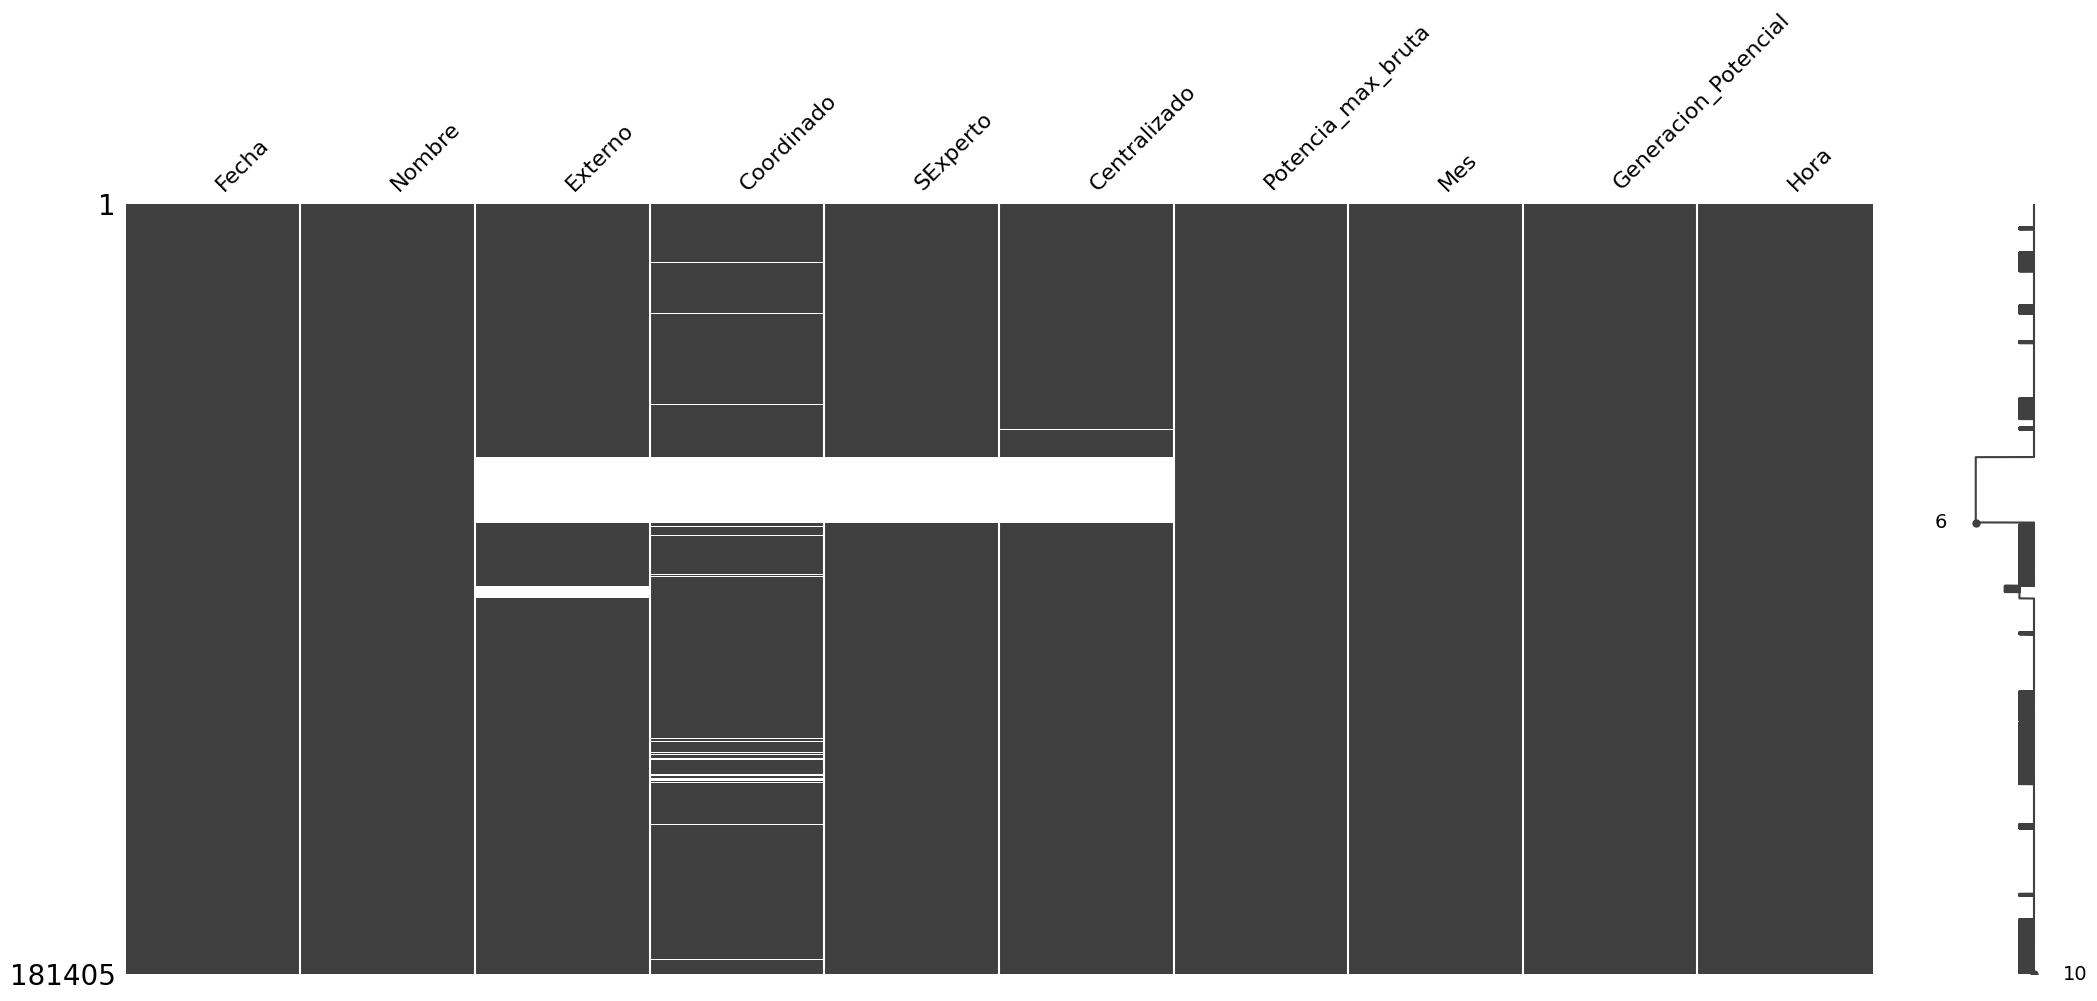

In [21]:
df_limpio.sort_values('Fecha')
msno.matrix(df_limpio.sort_values('Fecha'))

In [22]:
# Calcular el coeficiente de asimetría
pronosticos = ['Generacion_Potencial', 'Externo', 'Coordinado', 'SExperto']
print(pronosticos)
for i in pronosticos:

  skewness = df_limpio[i].skew()
  print(f"Coeficiente de Asimetría: {skewness}")

  # Interpretación del resultado
  if skewness > 0:
      print(f"La distribución de {i} tiene un sesgo positivo (hacia la derecha).")
  elif skewness < 0:
      print(f"La distribución de {i} tiene un sesgo negativo (hacia la izquierda).")
  else:
      print(f"La distribución de {i} es aproximadamente simétrica.")
del skewness, pronosticos, i

['Generacion_Potencial', 'Externo', 'Coordinado', 'SExperto']
Coeficiente de Asimetría: 1.6697102751467838
La distribución de Generacion_Potencial tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 1.5615554697904188
La distribución de Externo tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 1.5600369614441312
La distribución de Coordinado tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 1.4782867698459303
La distribución de SExperto tiene un sesgo positivo (hacia la derecha).


In [23]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_limpio.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Coordinado              11.089551
Externo                 10.136986
Centralizado             8.501971
SExperto                 8.493151
Fecha                    0.000000
Nombre                   0.000000
Potencia_max_bruta       0.000000
Mes                      0.000000
Generacion_Potencial     0.000000
Hora                     0.000000
dtype: float64


In [24]:
# Conteo de filas con valores faltantes
filas_con_faltantes = df_limpio.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor faltante: {filas_con_faltantes}")
del filas_con_faltantes

Número de filas con al menos un valor faltante: 22929


In [25]:
df_limpio = df_limpio.sort_values('Fecha').drop(columns={'Mes'})
df_imputado = df_limpio.interpolate()

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\3994977607.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_imputado = df_limpio.interpolate()


In [26]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado .isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Fecha                   0.0
Nombre                  0.0
Externo                 0.0
Coordinado              0.0
SExperto                0.0
Centralizado            0.0
Potencia_max_bruta      0.0
Generacion_Potencial    0.0
Hora                    0.0
dtype: float64


In [27]:
mask = df_imputado.isna().any(axis=1)

# Filtrar el DataFrame para mostrar solo esas filas
df_con_valores_vacios = df_imputado[mask]

print(df_con_valores_vacios['Fecha'].dt.hour.unique())
del df_con_valores_vacios,  mask

[]


In [28]:
df_imputado = df_imputado.fillna(0)

In [29]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Fecha                   0.0
Nombre                  0.0
Externo                 0.0
Coordinado              0.0
SExperto                0.0
Centralizado            0.0
Potencia_max_bruta      0.0
Generacion_Potencial    0.0
Hora                    0.0
dtype: float64


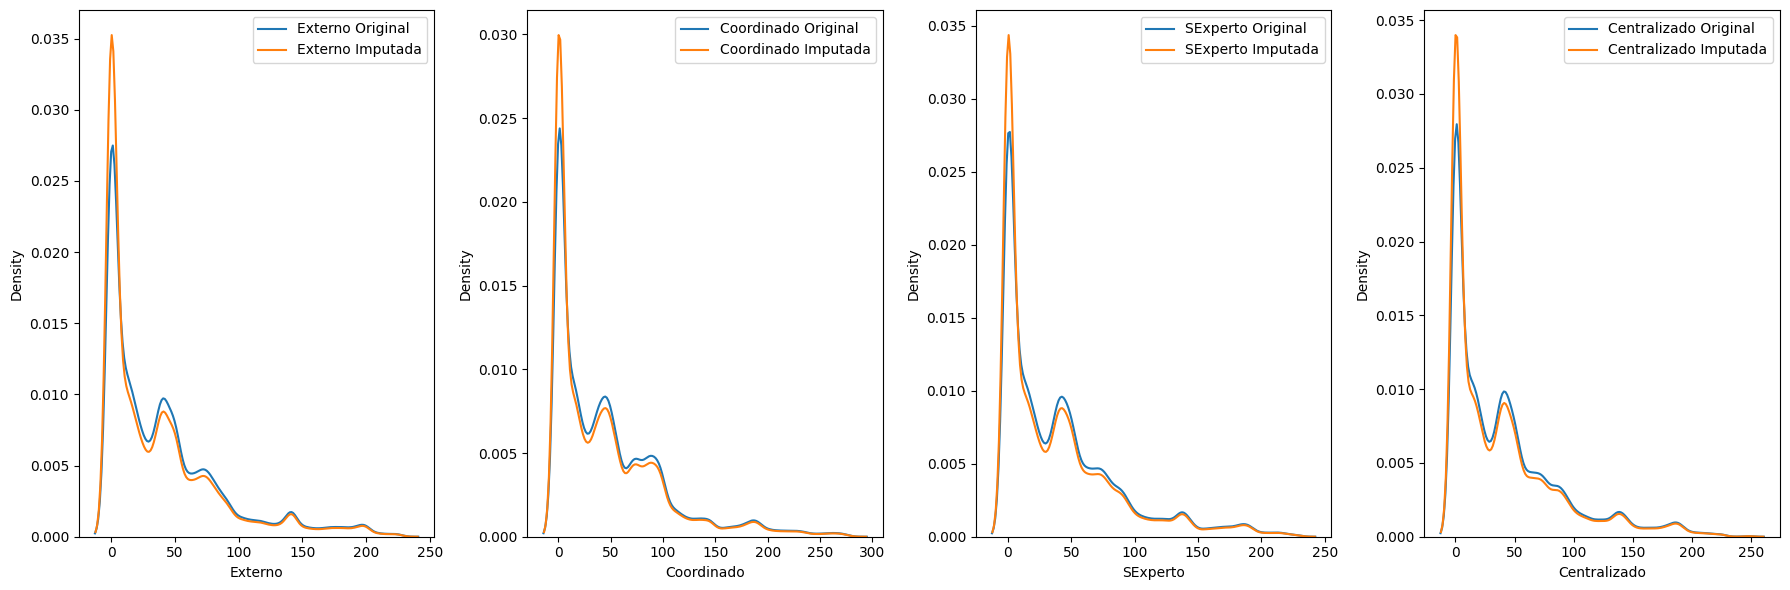

In [30]:
columnas = ['Externo', 'Coordinado', 'SExperto', 'Centralizado']

plt.figure(figsize=(18, 6))
for i, columna in enumerate(columnas, 1):
    plt.subplot(1, len(columnas), i)
    sn.kdeplot(df_limpio[f'{columna}'].dropna(), label=f'{columna} Original')
    sn.kdeplot(df_imputado[f'{columna}'], label=f'{columna} Imputada')
    plt.legend()
plt.tight_layout()
plt.show()
del columnas, i

In [31]:
df_bruto = df_limpio.copy()
df_limpio = df_imputado.copy()

## Analisis exploratorio

In [32]:
central = 'PFV JAMA'
datos_central = df_limpio[df_limpio['Nombre']== central]

In [33]:
hor4= datos_central[datos_central['Hora'] == 6]

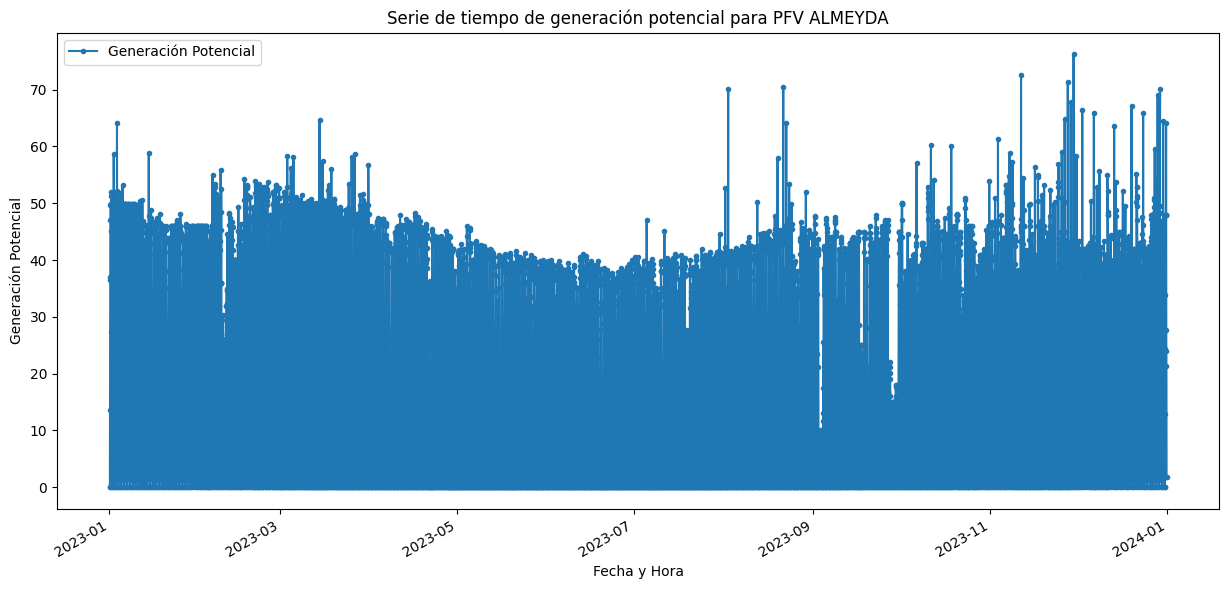

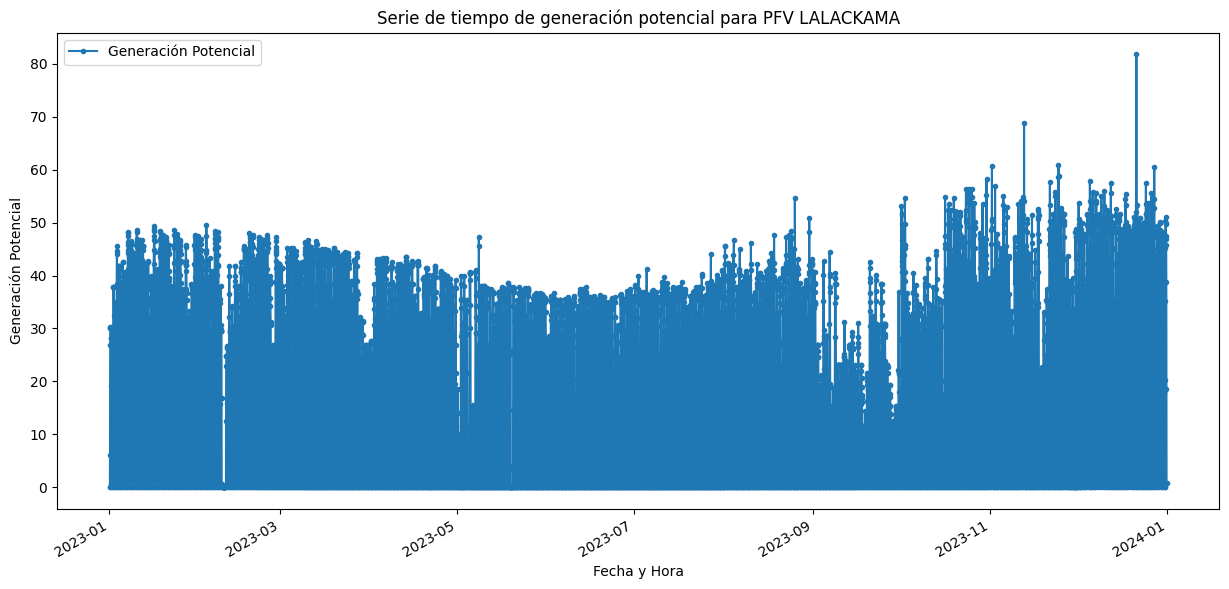

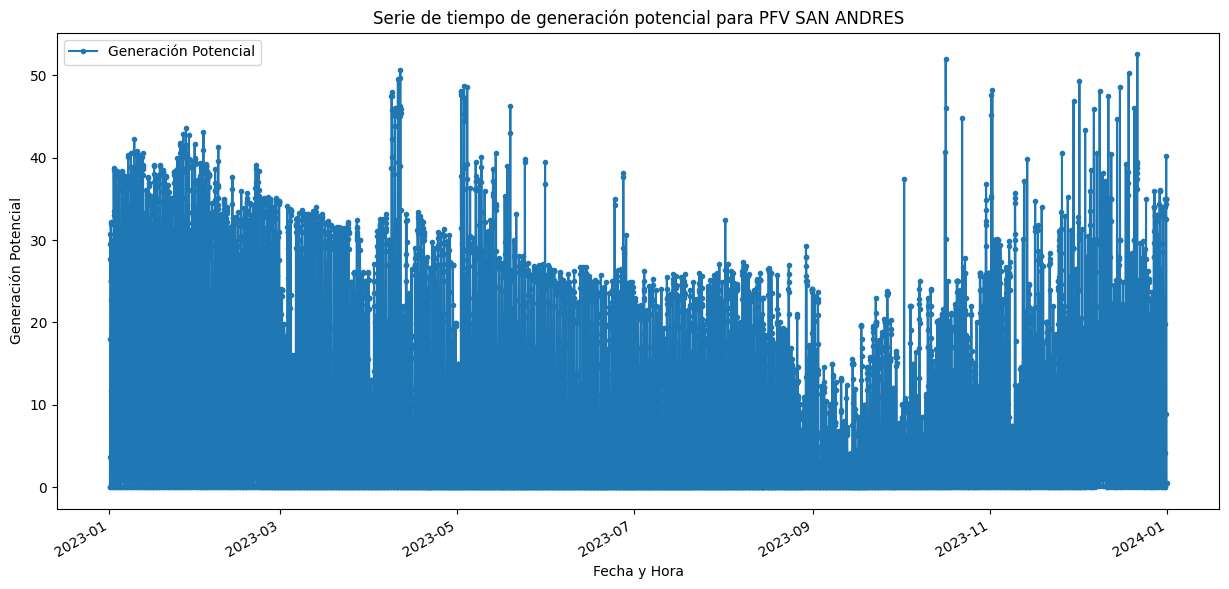

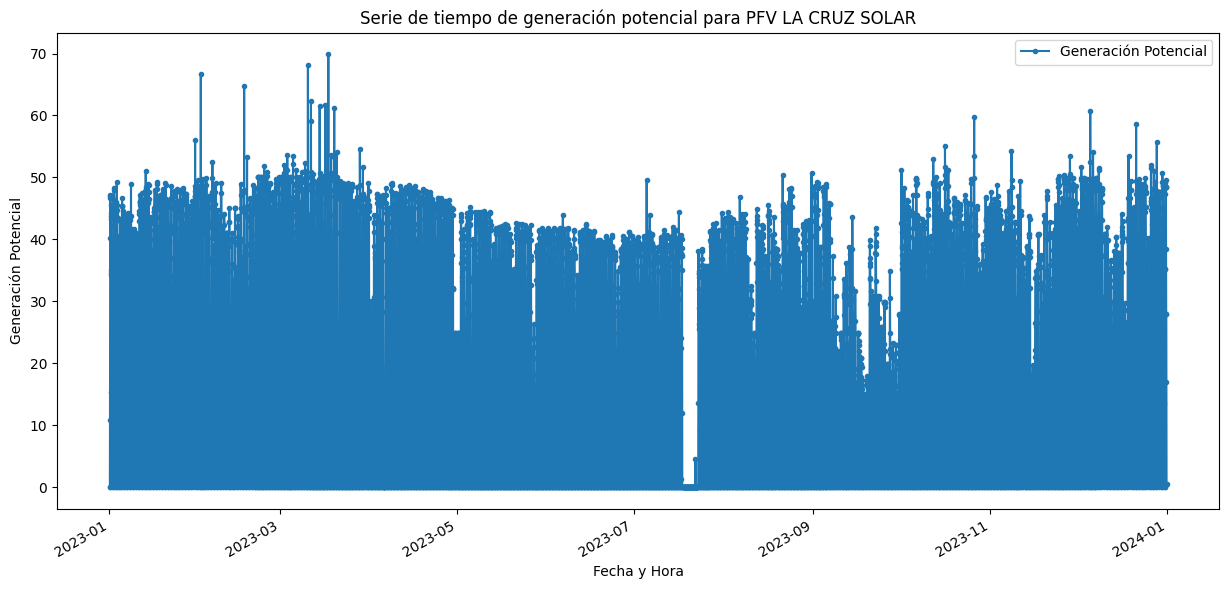

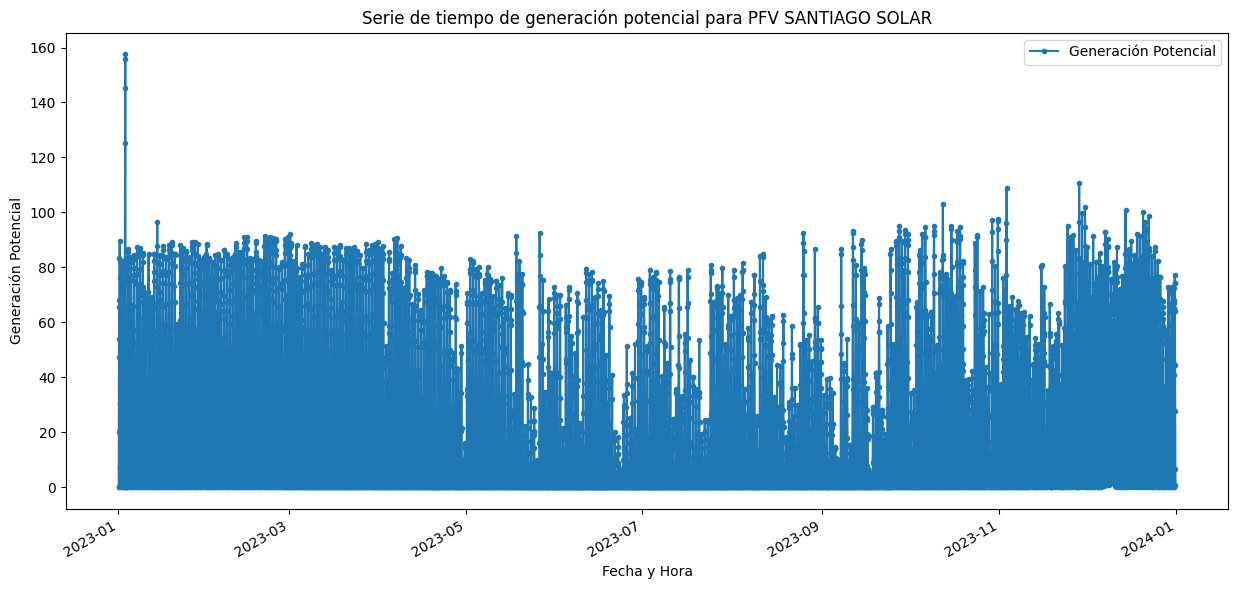

In [34]:
centrales_unicas = df_limpio['Nombre'].unique()[:5]

# Iterar sobre cada central única
for central in centrales_unicas:
    # Filtrar los datos para la central actual
    datos_central = df_limpio[df_limpio['Nombre'] == central]
    
    # Asegurarse de que los datos estén ordenados por fecha
    datos_central = datos_central.sort_values(by='Fecha')
    
    # Crear un nuevo gráfico
    plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación potencial
    plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Potencial', marker='o', linestyle='-', markersize=3)
    
    # Añadir título y leyenda al gráfico
    plt.title(f"Serie de tiempo de generación potencial para {central}")
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Generación Potencial')
    plt.legend()
    
    # Mejorar el formato de la fecha en el eje x
    plt.gcf().autofmt_xdate()
    
    # Mostrar el gráfico
    plt.show()

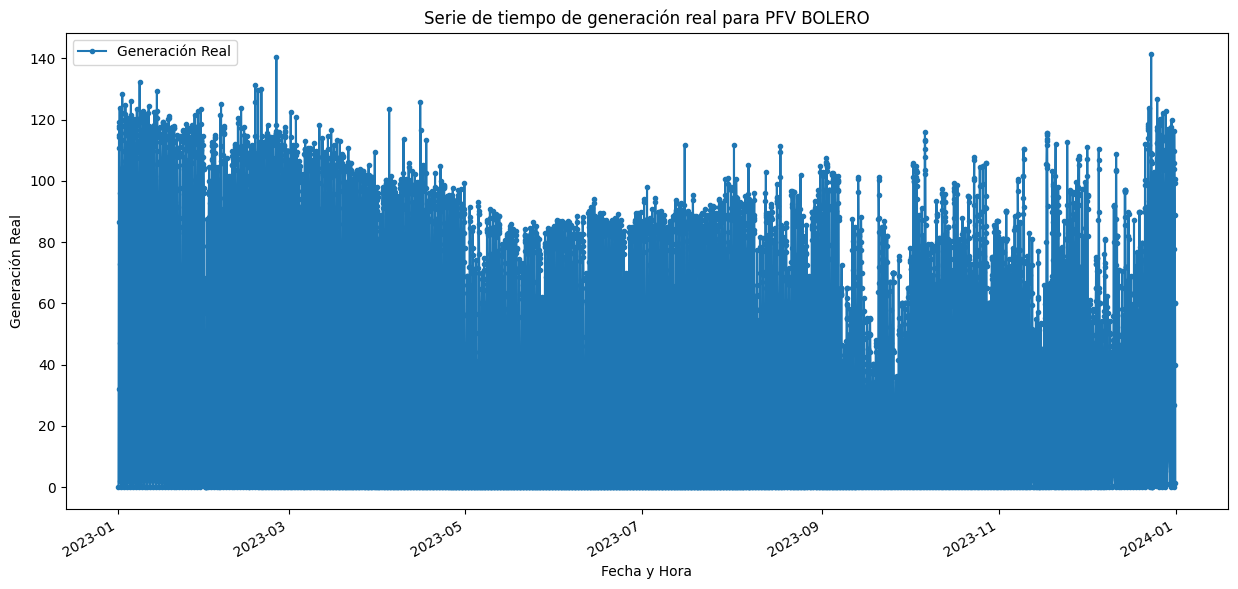

In [35]:
#Filtrar  datos por central
central = 'PFV BOLERO'
datos_central = df_limpio[df_limpio['Nombre']== central]

# Asegurarse de que los datos estén ordenados por fecha
datos_central = datos_central.sort_values(by='Fecha')

 # Crear un nuevo gráfico
plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación real
plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Real', marker='o', linestyle='-', markersize=3)

  # Añadir título y leyenda al gráfico
plt.title(f"Serie de tiempo de generación real para {central}")
plt.xlabel('Fecha y Hora')
plt.ylabel('Generación Real')
plt.legend()

# Mejorar el formato de la fecha en el eje x
plt.gcf().autofmt_xdate()

# Mostrar el gráfico
plt.show()




In [36]:
print(len(df_limpio[df_limpio['Nombre']== 'BOLERO']['Hora'].unique()))
df_limpio[df_limpio['Nombre']== 'PFV BOLERO']['Hora'].unique()


0


array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

# Regresión

In [37]:
Y = datos_central['Generacion_Potencial']
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

In [38]:
X

,const,Externo,Coordinado,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21
17155,1.0,19.4,13.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18771,1.0,78.0,89.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20395,1.0,100.4,114.08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21656,1.0,107.0,116.55,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21662,1.0,112.2,118.82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20127,1.0,63.0,98.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19984,1.0,59.9,84.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19973,1.0,29.1,36.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19295,1.0,1.1,0.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Sliding window

In [39]:
horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV BOLERO']['Hora'].unique()
horas_relevantes

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [40]:
# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Multiplica por la cantidad de horas relevantes por día para obtener el punto de corte
punto_corte = num_dias_entrenamiento * len(horas_relevantes)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()
potencia_maxima = datos_central['Potencia_max_bruta'].max()


365


In [41]:

# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones
for dia in range(dias_totales - num_dias_entrenamiento):
    # Definir el conjunto de entrenamiento para la ventana actual
    inicio = dia * filas_por_dia
    fin = inicio + num_dias_entrenamiento * filas_por_dia
    X_train = X.iloc[inicio:fin]
    Y_train = Y.iloc[inicio:fin]

    # Ajustar el modelo
    modelo = sm.OLS(Y_train, X_train).fit()

    # Extraer y almacenar los parámetros estimados para la fecha actual
    parametros_actuales = modelo.params
    parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

    # Realizar predicciones para el siguiente día
    X_test = X.iloc[fin:fin + filas_por_dia]
    predicciones = modelo.predict(X_test)

    # Aplicar el límite inferior y superior a las predicciones
    predicciones = np.maximum(predicciones, 0)  # Límite inferior, asegurando que la predicción no sea menor que 0
    predicciones = np.minimum(predicciones, potencia_maxima)  # Límite superior

    # Almacenar las predicciones
    predicciones_df = pd.concat([predicciones_df, predicciones])

    # Almacenar las variables utilizadas para la predicción del nuevo día
    variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
predicciones_df.rename(columns={0:'pred'},inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
del X, X_train, X_test


        const   Externo  Coordinado        h_8        h_9       h_10  \
0    0.022774  0.000537   -0.001166 -11.905293 -50.592656   2.702344   
1    0.022203  0.000648   -0.001202  -9.953827 -12.937619  23.581029   
2    0.021630  0.000782   -0.001257  -8.108094  12.995281  48.613072   
3    0.020986  0.000998   -0.001369  -6.969466  26.876933  57.897479   
4    0.020310  0.001219   -0.001478  -6.297579  31.431659  60.793491   
..        ...       ...         ...        ...        ...        ...   
240 -0.009778  0.006265    0.010710  -9.295530  40.270725  25.070757   
241 -0.011645  0.006395    0.010451  -9.420365  42.363799  26.001895   
242 -0.010535  0.006307    0.010364  -9.590532  44.587339  26.741174   
243 -0.069392  0.023099    0.009020  -9.975300  44.580725  26.113109   
244 -0.064961  0.022123    0.009482  -9.839292  45.592752  26.363183   

          h_11       h_12       h_13       h_14  ...  Coordinado-h_12  \
0    34.928377  37.411592  31.795694  26.616476  ...         0

#  Prediction Dataset

In [42]:
dc245  = pd.DataFrame()
dc245 = datos_central.iloc[num_dias_entrenamiento*filas_por_dia:]
dc245.reset_index(inplace=True)
dc245['pred'] = predicciones_df['pred']
dc245['dia'] = dc245['Fecha'].dt.date
# Usar factorize() para crear los identificadores únicos
dc245['identificador'] = pd.factorize(dc245['dia'])[0]
dc245

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\4011148655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['pred'] = predicciones_df['pred']
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\4011148655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['dia'] = dc245['Fecha'].dt.date
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\4011148655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,index,Fecha,Nombre,Externo,Coordinado,SExperto,Centralizado,Potencia_max_bruta,Generacion_Potencial,Hora,pred,dia,identificador
0,17374,2023-05-01 07:00:00,PFV BOLERO,0.0,0.00,0.000,0.00,138.2,0.000000,7,0.022774,2023-05-01,0
1,18620,2023-05-01 08:00:00,PFV BOLERO,0.0,0.00,0.000,0.00,138.2,10.610000,8,0.000000,2023-05-01,0
2,19177,2023-05-01 09:00:00,PFV BOLERO,0.0,0.00,0.000,0.00,138.2,35.870000,9,0.000000,2023-05-01,0
3,19248,2023-05-01 10:00:00,PFV BOLERO,0.0,0.00,0.000,0.00,138.2,38.080000,10,2.725118,2023-05-01,0
4,19847,2023-05-01 11:00:00,PFV BOLERO,0.0,0.00,0.000,0.00,138.2,56.430000,11,34.951151,2023-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,20127,2023-12-31 17:00:00,PFV BOLERO,63.0,98.11,66.904,98.11,138.2,88.796172,17,67.434449,2023-12-31,244
3671,19984,2023-12-31 18:00:00,PFV BOLERO,59.9,84.89,62.589,84.89,138.2,60.147182,18,64.478026,2023-12-31,244
3672,19973,2023-12-31 19:00:00,PFV BOLERO,29.1,36.07,29.862,36.07,138.2,60.068958,19,59.634879,2023-12-31,244
3673,19295,2023-12-31 20:00:00,PFV BOLERO,1.1,0.64,1.048,0.64,138.2,39.960101,20,42.824540,2023-12-31,244


## Outliers

In [43]:
# Calculando el rango intercuartílico (IQR)
Q1 = dc245['pred'].quantile(0.25)
Q3 = dc245['pred'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = dc245[(dc245['pred'] < limite_inferior) | (dc245['pred'] > limite_superior)]
no_outliers = dc245[(dc245['pred'] >= limite_inferior) & (dc245['pred'] <= limite_superior)]

print("Outliers:")
print(outliers)
#print("\nDatos sin outliers:")
#print(no_outliers)


Outliers:
Empty DataFrame
Columns: [index, Fecha, Nombre, Externo, Coordinado, SExperto, Centralizado, Potencia_max_bruta, Generacion_Potencial, Hora, pred, dia, identificador]
Index: []


# Errores

In [44]:
error = pd.DataFrame()
error['Fecha'] = datos_central['Fecha'].iloc[num_dias_entrenamiento*filas_por_dia:]
error.reset_index(inplace=True, drop='index')

#Regresión
error['error_regresion'] = dc245['Generacion_Potencial']- dc245['pred']# Calcular el MAE y RMSE
error['MAE_regresion'] = np.abs(error['error_regresion'])
error['RMSE_regresion'] = error['error_regresion'] ** 2

#Externo
error['err_externo'] = dc245['Generacion_Potencial']- dc245['Externo']
error['MAE_externo'] = np.abs(error['err_externo'])
error['RMSE_externo'] = error['err_externo'] ** 2

#Coordinado
error['err_Coordinado'] = dc245['Generacion_Potencial']- dc245['Coordinado']
error['MAE_coordinado'] = np.abs(error['err_Coordinado'])
error['RMSE_coordinado'] = error['err_Coordinado'] ** 2

#SExperto
error['err_SExperto'] = dc245['Generacion_Potencial']- dc245['SExperto']
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2

#Centralizado
error['err_Centralizado'] = dc245['Generacion_Potencial']- dc245['Centralizado']
error['MAE_Centralizado'] = np.abs(error['err_Centralizado'])
error['RMSE_Centralizado'] = error['err_Centralizado'] ** 2



In [45]:
error

,Fecha,error_regresion,MAE_regresion,RMSE_regresion,err_externo,MAE_externo,RMSE_externo,err_Coordinado,MAE_coordinado,RMSE_coordinado,err_SExperto,MAE_SExperto,RMSE_SExperto,err_Centralizado,MAE_Centralizado,RMSE_Centralizado
0,2023-05-01 07:00:00,-0.022774,0.022774,0.000519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-05-01 08:00:00,10.610000,10.610000,112.572100,10.610000,10.610000,112.572100,10.610000,10.610000,112.572100,10.610000,10.610000,112.572100,10.610000,10.610000,112.572100
2,2023-05-01 09:00:00,35.870000,35.870000,1286.656900,35.870000,35.870000,1286.656900,35.870000,35.870000,1286.656900,35.870000,35.870000,1286.656900,35.870000,35.870000,1286.656900
3,2023-05-01 10:00:00,35.354882,35.354882,1249.967656,38.080000,38.080000,1450.086400,38.080000,38.080000,1450.086400,38.080000,38.080000,1450.086400,38.080000,38.080000,1450.086400
4,2023-05-01 11:00:00,21.478849,21.478849,461.340952,56.430000,56.430000,3184.344900,56.430000,56.430000,3184.344900,56.430000,56.430000,3184.344900,56.430000,56.430000,3184.344900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,2023-12-31 17:00:00,21.361723,21.361723,456.323222,25.796172,25.796172,665.442490,-9.313828,9.313828,86.747392,21.892172,21.892172,479.267195,-9.313828,9.313828,86.747392
3671,2023-12-31 18:00:00,-4.330843,4.330843,18.756204,0.247182,0.247182,0.061099,-24.742818,24.742818,612.207034,-2.441818,2.441818,5.962474,-24.742818,24.742818,612.207034
3672,2023-12-31 19:00:00,0.434079,0.434079,0.188424,30.968958,30.968958,959.076360,23.998958,23.998958,575.949985,30.206958,30.206958,912.460312,23.998958,23.998958,575.949985
3673,2023-12-31 20:00:00,-2.864439,2.864439,8.205013,38.860101,38.860101,1510.107412,39.320101,39.320101,1546.070304,38.912101,38.912101,1514.151566,39.320101,39.320101,1546.070304


##  Error granularidad diaria

In [46]:
error_diario = pd.DataFrame()
error_diario['MAE_regresion'] = (error.groupby(error['Fecha'].dt.date)['MAE_regresion'].mean() /potencia_maxima) 
error_diario['RMSE_regresion'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_regresion'].mean() /potencia_maxima))

error_diario['MAE_externo'] = (error.groupby(error['Fecha'].dt.date)['MAE_externo'].mean() /potencia_maxima) 
error_diario['RMSE_externo'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_externo'].mean() /potencia_maxima))


error_diario['MAE_coordinado'] = (error.groupby(error['Fecha'].dt.date)['MAE_coordinado'].mean() /potencia_maxima) 
error_diario['RMSE_coordinado'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_coordinado'].mean() /potencia_maxima))


error_diario['MAE_SExperto'] = (error.groupby(error['Fecha'].dt.date)['MAE_SExperto'].mean() /potencia_maxima) 
error_diario['RMSE_SExperto'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_SExperto'].mean() /potencia_maxima))

error_diario['MAE_Centralizado'] = (error.groupby(error['Fecha'].dt.date)['MAE_Centralizado'].mean() /potencia_maxima) 
error_diario['RMSE_Centralizado'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_Centralizado'].mean() /potencia_maxima))

In [47]:
error_diario

,MAE_regresion,RMSE_regresion,MAE_externo,RMSE_externo,MAE_coordinado,RMSE_coordinado,MAE_SExperto,RMSE_SExperto,MAE_Centralizado,RMSE_Centralizado
Fecha,,,,,,,,,,
2023-05-01,0.162591,2.356818,0.271375,3.999498,0.271375,3.999498,0.271375,3.999498,0.271375,3.999498
2023-05-02,0.185891,2.861665,0.356112,5.238018,0.356112,5.238018,0.356112,5.238018,0.356112,5.238018
2023-05-03,0.113590,1.787848,0.315494,4.686822,0.315494,4.686822,0.315494,4.686822,0.315494,4.686822
2023-05-04,0.095172,1.430251,0.229691,3.608539,0.229691,3.608539,0.229691,3.608539,0.229691,3.608539
2023-05-05,0.144674,1.987000,0.384969,5.679133,0.384969,5.679133,0.384969,5.679133,0.384969,5.679133
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.185806,2.553297,0.326801,4.204076,0.113390,1.978292,0.309037,3.965532,0.113574,1.981677
2023-12-28,0.195306,2.643699,0.315554,4.031880,0.109312,2.040450,0.296293,3.785740,0.109486,2.043768
2023-12-29,0.179334,2.461329,0.226714,3.090684,0.069432,1.313810,0.206055,2.819060,0.069751,1.323381


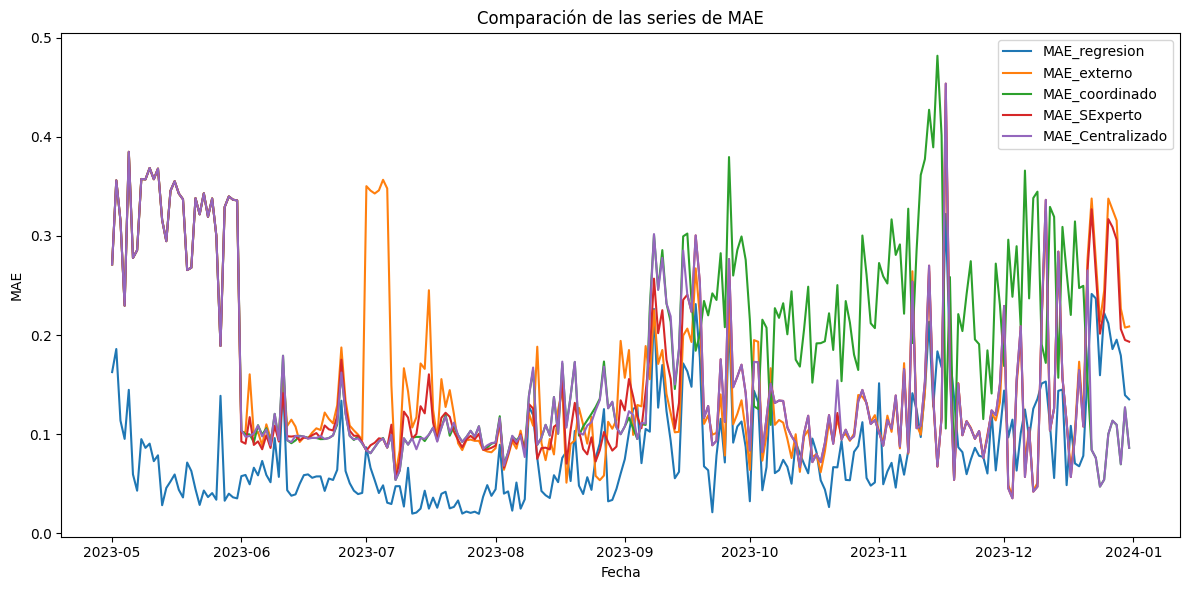

In [48]:


# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_diario.columns:
    if column.startswith('MAE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


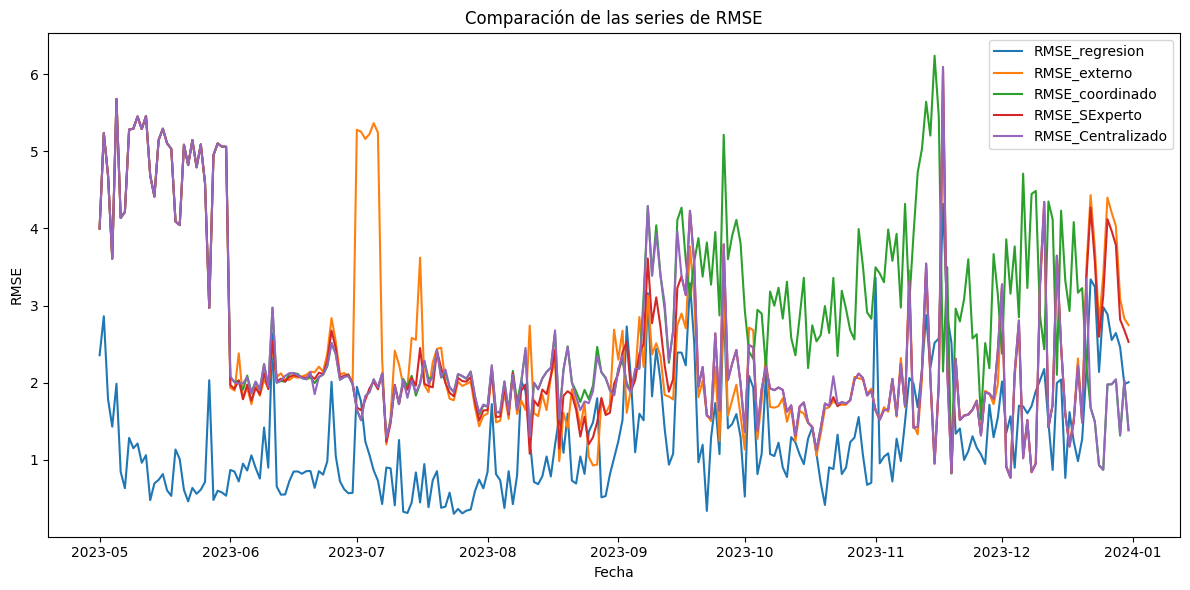

In [49]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_diario.columns:
    if column.startswith('RMSE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad semanal

In [50]:
# Agrupar por semana y calcular el MAE semanal para cada tipo de error
error_semanal = pd.DataFrame()

error_semanal['MAE_regresion'] = (error.resample('W', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_semanal['RMSE_regresion'] = (error.resample('W', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_externo'] = (error.resample('W', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_semanal['RMSE_externo'] = (error.resample('W', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_coordinado'] = (error.resample('W', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_semanal['RMSE_coordinado'] = (error.resample('W', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_SExperto'] = (error.resample('W', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_semanal['RMSE_SExperto'] = (error.resample('W', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_Centralizado'] = (error.resample('W', on='Fecha')['MAE_Centralizado'].mean() / potencia_maxima)
error_semanal['RMSE_Centralizado'] = (error.resample('W', on='Fecha')['RMSE_Centralizado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)
# Asegúrate de que 'potencia_maxima' es un escalar si es constante para todo el período o una serie con índices de fecha si varía a lo largo del tiempo.
# Si 'potencia_maxima' varía, deberías hacer un resample de esa serie también y usar el valor semanal correspondiente para cada cálculo.

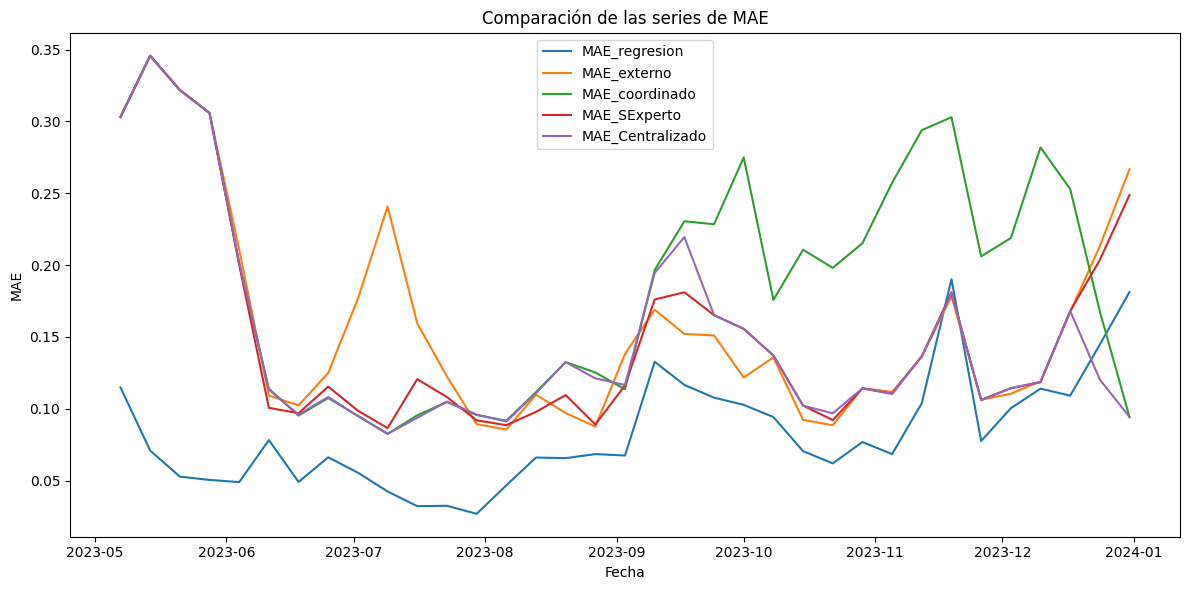

In [51]:

# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_semanal.columns:
    if column.startswith('MAE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

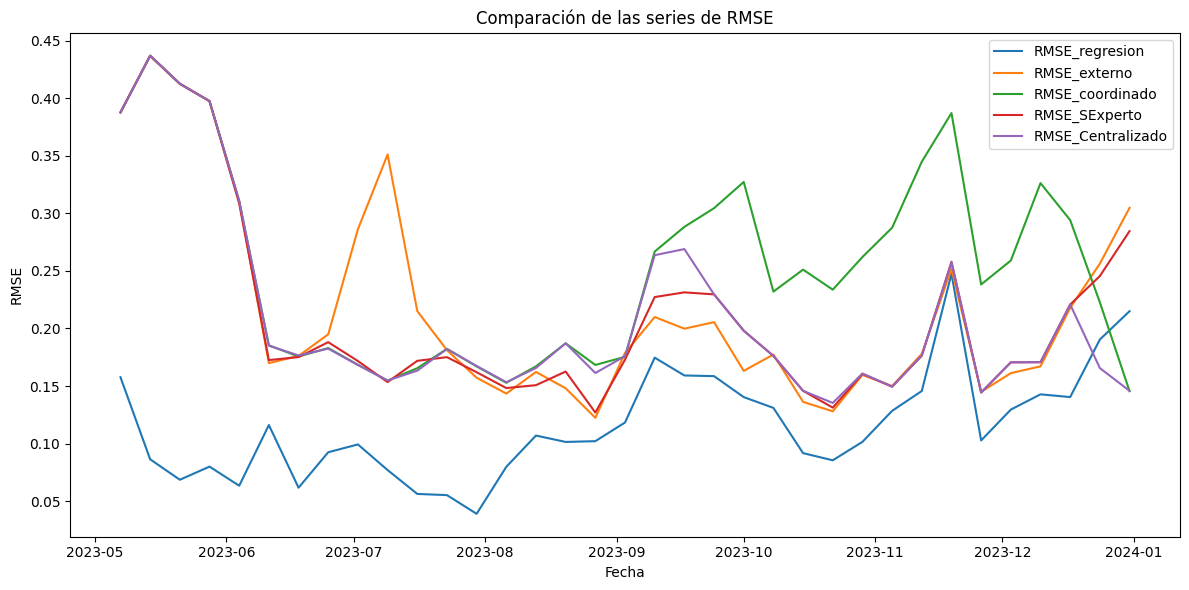

In [52]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_semanal.columns:
    if column.startswith('RMSE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad mensual

In [53]:
# Agrupar por mes y calcular el MAE mensual para cada tipo de error
error_mensual = pd.DataFrame()

error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_mensual['RMSE_externo'] = (error.resample('M', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_coordinado'] = (error.resample('M', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_mensual['RMSE_coordinado'] = (error.resample('M', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_SExperto'] = (error.resample('M', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_mensual['RMSE_SExperto'] = (error.resample('M', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_Centralizado'] = (error.resample('M', on='Fecha')['MAE_Centralizado'].mean() / potencia_maxima)
error_mensual['RMSE_Centralizado'] = (error.resample('M', on='Fecha')['RMSE_Centralizado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2108973427.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2108973427.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2108973427.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2108973427.py:8: FutureWarning: 'M' is deprecated and will be removed in a fu

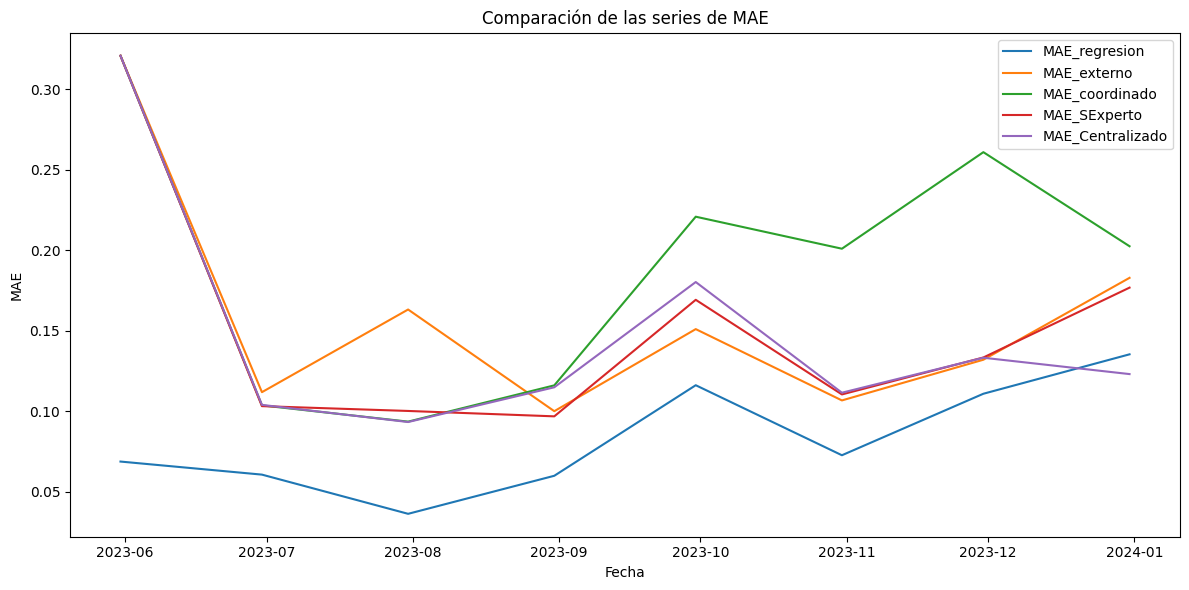

In [54]:
# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_mensual.columns:
    if column.startswith('MAE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

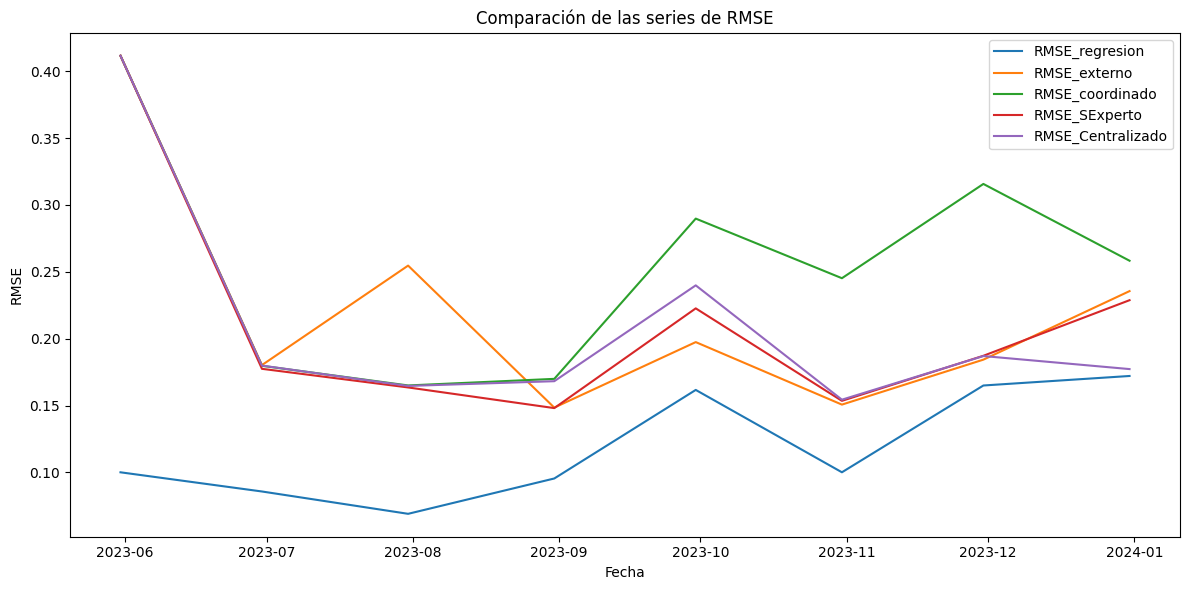

In [55]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_mensual.columns:
    if column.startswith('RMSE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error total

In [56]:
# Calcular el MAE y RMSE totales para el período completo para cada tipo de error
error_total = pd.DataFrame(index=['Total'])

error_total['MAE_regresion'] = error['MAE_regresion'].mean() / potencia_maxima
error_total['RMSE_regresion'] = np.sqrt(error['RMSE_regresion'].mean()) / potencia_maxima

error_total['MAE_externo'] = error['MAE_externo'].mean() / potencia_maxima
error_total['RMSE_externo'] = np.sqrt(error['RMSE_externo'].mean()) / potencia_maxima

error_total['MAE_coordinado'] = error['MAE_coordinado'].mean() / potencia_maxima
error_total['RMSE_coordinado'] = np.sqrt(error['RMSE_coordinado'].mean()) / potencia_maxima

error_total['MAE_SExperto'] = error['MAE_SExperto'].mean() / potencia_maxima
error_total['RMSE_SExperto'] = np.sqrt(error['RMSE_SExperto'].mean()) / potencia_maxima


error_total['MAE_Centralizado'] = error['MAE_Centralizado'].mean() / potencia_maxima
error_total['RMSE_Centralizado'] = np.sqrt(error['RMSE_Centralizado'].mean()) / potencia_maxima

# Imprimir los errores totales
print(error_total)

       MAE_regresion  RMSE_regresion  MAE_externo  RMSE_externo  \
Total       0.082523         0.12442     0.158976      0.235005   

       MAE_coordinado  RMSE_coordinado  MAE_SExperto  RMSE_SExperto  \
Total        0.189923         0.266482      0.151639       0.226739   

       MAE_Centralizado  RMSE_Centralizado  
Total          0.147821           0.225213  


# Generación Consolidado

## Regresión

In [57]:
len(consolidado)

NameError: name 'consolidado' is not defined

In [58]:
centrales = df_limpio['Nombre'].unique()[:]
# Crear un diccionario para almacenar las predicciones de cada central
consolidado= {}
for central in centrales:
    #definimos la central
    central_brutos =df_bruto[df_bruto['Nombre']== central]
    datos_central = df_limpio[df_limpio['Nombre']== central]
    
    
    #Definimas las variables
    Y = datos_central['Generacion_Potencial']
    dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
    dummies = dummies.astype(float)
    X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
    X = sm.add_constant(X)
    
    # Definimos las interacciones 
    var_ind = ['Externo', 'Coordinado']
    for var in var_ind:
        for dummie in dummies.columns:
            nombre_interaccion = f'{var}-{dummie}'
            X[nombre_interaccion] = X[var] * X[dummie]
    parametros = {}
    # Definir parámetros específicos de la central
    horas_relevantes = datos_central['Hora'].unique()
    num_dias_entrenamiento = 120
    filas_por_dia = len(horas_relevantes)
    dias_totales = len(X) // filas_por_dia
    potencia_maxima = datos_central['Potencia_max_bruta'].max()
    parametros = {
        'num_dias_entrenamiento':num_dias_entrenamiento,
        'filas_por_dia': filas_por_dia,
         'dias_totales': dias_totales,
         'potencia_maxima': potencia_maxima
    }
    
    # Inicializar DataFrames temporales para esta central
    predicciones_df = pd.DataFrame()
    parametros_df = pd.DataFrame()
    variables_prediccion_df = pd.DataFrame()
    
    # Iterar a través de los días, ajustando el modelo y realizando predicciones
    for dia in range(dias_totales - num_dias_entrenamiento):
        # Definir el conjunto de entrenamiento para la ventana actual
        inicio = dia * filas_por_dia
        fin = inicio + num_dias_entrenamiento * filas_por_dia
        X_train = X.iloc[inicio:fin]
        Y_train = Y.iloc[inicio:fin]

        # Ajustar el modelo
        modelo = sm.OLS(Y_train, X_train).fit()

        # Extraer y almacenar los parámetros estimados para la fecha actual
        parametros_actuales = modelo.params
        parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

        # Realizar predicciones para el siguiente día
        X_test = X.iloc[fin:fin + filas_por_dia]
        predicciones = modelo.predict(X_test)
        # Aplicar el límite inferior y superior a las predicciones
        predicciones = np.maximum(predicciones, 0)  # Límite inferior, asegurando que la predicción no sea menor que 0
        predicciones = np.minimum(predicciones, potencia_maxima)  # Límite superior

        # Almacenar las predicciones
        predicciones_df = pd.concat([predicciones_df, predicciones])
        # Almacenar las variables utilizadas para la predicción del nuevo día
        variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

    # Almacenar los resultados en el diccionario, usando el nombre de la central como clave
    predicciones_df.rename(columns={0:'pred'},inplace=True)
    consolidado[central] = {
        'datos_central':central_brutos,
        'parametros': parametros,
        'parametros_modelo': parametros_df.reset_index(drop=True),
        'predicciones': predicciones_df.reset_index(drop=True),
        'variables_prediccion': variables_prediccion_df.reset_index(drop=True)
    }
    
    # Opcional: Limpieza de variables para optimizar la memoria
    del X, X_train, X_test, Y, dummies, parametros_df, predicciones_df, variables_prediccion_df
    


In [59]:
for central in consolidado.keys():
    print(central)

PFV ALMEYDA
PFV LALACKAMA
PFV SAN ANDRES
PFV LA CRUZ SOLAR
PFV SANTIAGO SOLAR
PFV CHAÑARES
PFV LOS LOROS
PFV LA HUELLA
PFV HUATACONDO
PFV TAMAYA SOLAR
PFV NUEVO QUILLAGUA
PFV FINIS TERRAE
PFV URIBE SOLAR
PFV ANDES SOLAR
PFV SOL DEL DESIERTO
PFV JAVIERA
PFV MALGARIDA
PFV DOÑA CARMEN SOLAR
PFV CONEJO SOLAR
PFV RIO ESCONDIDO
PFV QUILAPILUN
PFV MARIA ELENA
PFV LA HUAYCA II
PFV LLANO DE LLAMPOS
PFV ATACAMA SOLAR II
PFV EL ROMERO
PFV USYA
PFV BOLERO
PFV JAMA
PFV CERRO DOMINADOR
PFV EL PELICANO
PFV LALACKAMA II


In [60]:
rmse_centrales = pd.DataFrame()
rmse_mensuales = {}
df245 = pd.DataFrame()
dferror = pd.DataFrame()
parametrosC= pd.DataFrame()
parametrosModelo= pd.DataFrame()
for central in consolidado.keys():
    datos_central = consolidado[central]['datos_central']
    parametros_dict = consolidado[central]['parametros']
    parametros = pd.DataFrame([parametros_dict])  # Convertir el diccionario a DataFrame
    parametros['central'] = central  # Asegurar que 'central' se añade como columna al DataFrame
    predicciones = consolidado[central]['predicciones']
    potencia_maxima = parametros['potencia_maxima'].iloc[0]  # Asegurar acceso al valor correcto
    dc245  = pd.DataFrame()
    dc245 = datos_central.iloc[int(parametros_dict['num_dias_entrenamiento'])*int(parametros_dict['filas_por_dia']):]
    dc245.reset_index(inplace=True, drop=True)
     # Asegurar que solo se incluyan datos de junio a diciembre
    dc245 = dc245[dc245['Fecha'].dt.month >= 6]
    dc245['pred'] = predicciones['pred']
    dc245['dia'] = dc245['Fecha'].dt.date
    dc245['identificador'] = pd.factorize(dc245['dia'])[0]

    error = pd.DataFrame()
    error['central'] = dc245['Nombre']
    error['Fecha'] = dc245['Fecha']
    error.reset_index(inplace=True, drop='index')

    #Regresión
    error['error_regresion'] = dc245['Generacion_Potencial']- dc245['pred']# Calcular el MAE y RMSE
    error['MAE_regresion'] = np.abs(error['error_regresion'])
    error['RMSE_regresion'] = error['error_regresion'] ** 2

    #Externo
    error['err_externo'] = dc245['Generacion_Potencial']- dc245['Externo']
    error['MAE_externo'] = np.abs(error['err_externo'])
    error['RMSE_externo'] = error['err_externo'] ** 2

    #Coordinado
    error['err_Coordinado'] = dc245['Generacion_Potencial']- dc245['Coordinado']
    error['MAE_coordinado'] = np.abs(error['err_Coordinado'])
    error['RMSE_coordinado'] = error['err_Coordinado'] ** 2

    #SExperto
    error['err_SExperto'] = dc245['Generacion_Potencial']- dc245['SExperto']
    error['MAE_SExperto'] = np.abs(error['err_SExperto'])
    error['RMSE_SExperto'] = error['err_SExperto'] ** 2
    
    #Centralizado
    error['err_Centralizado'] = dc245['Generacion_Potencial']- dc245['Centralizado']
    error['MAE_Centralizado'] = np.abs(error['err_Centralizado'])
    error['RMSE_Centralizado'] = error['err_Centralizado'] ** 2
    
    
    ################# TOTALv############################
    # Calcular el MAE y RMSE totales para el período completo para cada tipo de error
    error_total = pd.DataFrame(index=['Total'])

    error_total['MAE_regresion'] = error['MAE_regresion'].mean() / potencia_maxima
    error_total['RMSE_regresion'] = np.sqrt(error['RMSE_regresion'].mean()) / potencia_maxima

    error_total['MAE_externo'] = error['MAE_externo'].mean() / potencia_maxima
    error_total['RMSE_externo'] = np.sqrt(error['RMSE_externo'].mean()) / potencia_maxima

    error_total['MAE_coordinado'] = error['MAE_coordinado'].mean() / potencia_maxima
    error_total['RMSE_coordinado'] = np.sqrt(error['RMSE_coordinado'].mean()) / potencia_maxima

    error_total['MAE_SExperto'] = error['MAE_SExperto'].mean() / potencia_maxima
    error_total['RMSE_SExperto'] = np.sqrt(error['RMSE_SExperto'].mean()) / potencia_maxima
    
    error_total['MAE_Centralizado'] = error['MAE_Centralizado'].mean() / potencia_maxima
    error_total['RMSE_Centralizado'] = np.sqrt(error['RMSE_Centralizado'].mean()) / potencia_maxima
    
    

     # Corrección aquí: Selecciona el primer elemento de la Serie con [0] para obtener un valor escalar
    rmse_centrales.loc[central, 'Regresión'] = error_total['RMSE_regresion'][0]
    rmse_centrales.loc[central, 'Externo'] = error_total['RMSE_externo'][0]
    rmse_centrales.loc[central, 'Coordinado'] = error_total['RMSE_coordinado'][0]
    rmse_centrales.loc[central, 'SExperto'] = error_total['RMSE_SExperto'][0]
    rmse_centrales.loc[central, 'Centralizado'] = error_total['RMSE_Centralizado'][0]
    #rmse_centrales /= potencia_maxima
    
    ################ MENSUAL##################
    error_mensual = pd.DataFrame()

    error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
    error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

    error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
    error_mensual['RMSE_externo'] = (error.resample('M', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

    error_mensual['MAE_coordinado'] = (error.resample('M', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
    error_mensual['RMSE_coordinado'] = (error.resample('M', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

    error_mensual['MAE_SExperto'] = (error.resample('M', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
    error_mensual['RMSE_SExperto'] = (error.resample('M', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)
    
    error_mensual['MAE_Centralizado'] = (error.resample('M', on='Fecha')['MAE_Centralizado'].mean() / potencia_maxima)
    error_mensual['RMSE_Centralizado'] = (error.resample('M', on='Fecha')['RMSE_Centralizado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

     # Se agregó código aquí para calcular los errores mensuales
    for mes, error_mes in error.groupby(error['Fecha'].dt.to_period('M')):
        if central not in rmse_mensuales:
            rmse_mensuales[central] = pd.DataFrame()
        
        rmse_mensuales[central].loc[mes, 'RMSE_regresion'] = np.sqrt(error_mes['RMSE_regresion'].mean()) / potencia_maxima
        rmse_mensuales[central].loc[mes, 'RMSE_externo'] = np.sqrt(error_mes['RMSE_externo'].mean()) / potencia_maxima
        rmse_mensuales[central].loc[mes, 'RMSE_coordinado'] = np.sqrt(error_mes['RMSE_coordinado'].mean()) / potencia_maxima
        rmse_mensuales[central].loc[mes, 'RMSE_SExperto'] = np.sqrt(error_mes['RMSE_SExperto'].mean()) / potencia_maxima
        rmse_mensuales[central].loc[mes, 'RMSE_Centralizado'] = np.sqrt(error_mes['RMSE_Centralizado'].mean()) / potencia_maxima
    dferror = pd.concat([dferror,error])
    df245 = pd.concat([df245, dc245], ignore_index=True)  
    parametrosC = pd.concat([parametrosC, parametros], ignore_index=True) 
df245 = df245.rename(columns={'pred':'regresion'})



C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2690416506.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_centrales.loc[central, 'Regresión'] = error_total['RMSE_regresion'][0]
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2690416506.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_centrales.loc[central, 'Externo'] = error_total['RMSE_externo'][0]
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_9872\2690416506.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

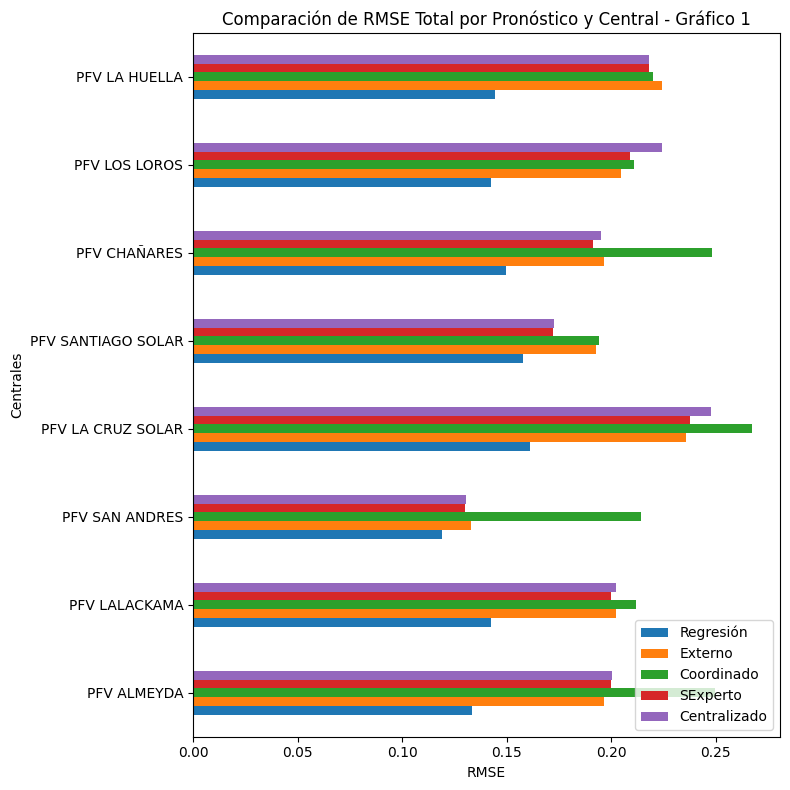

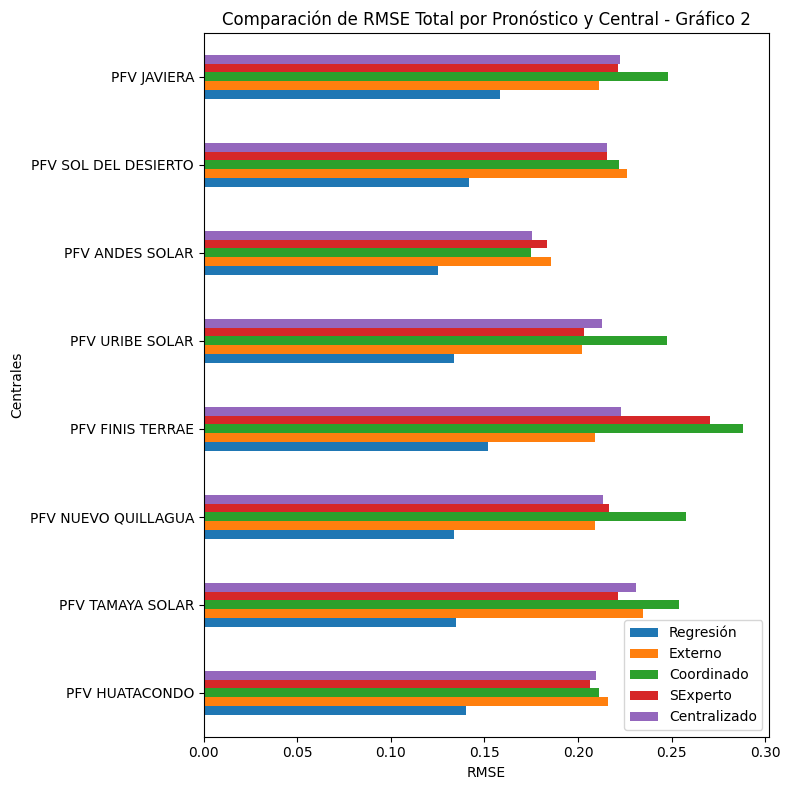

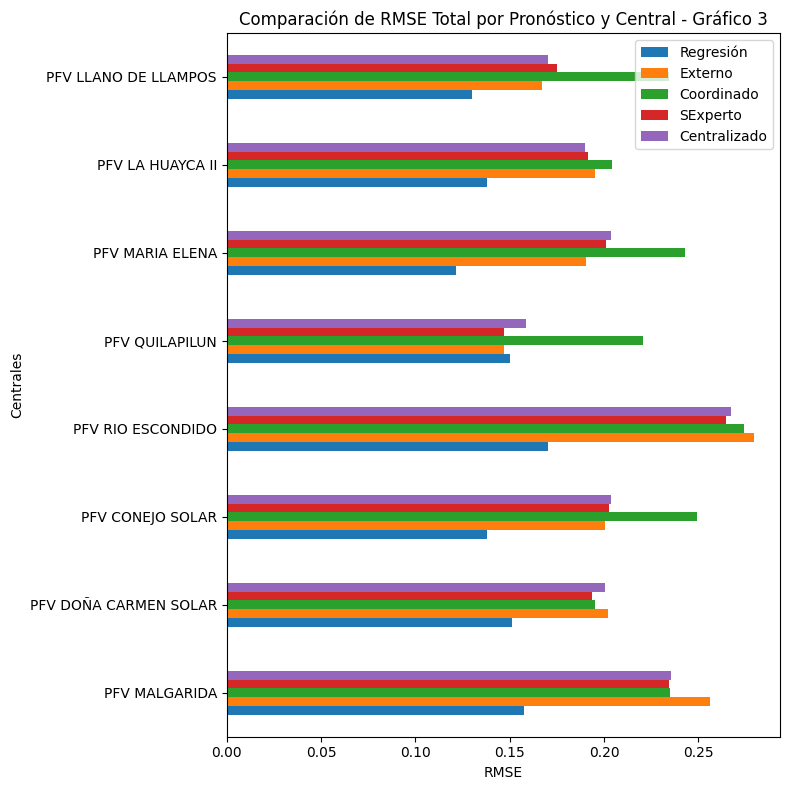

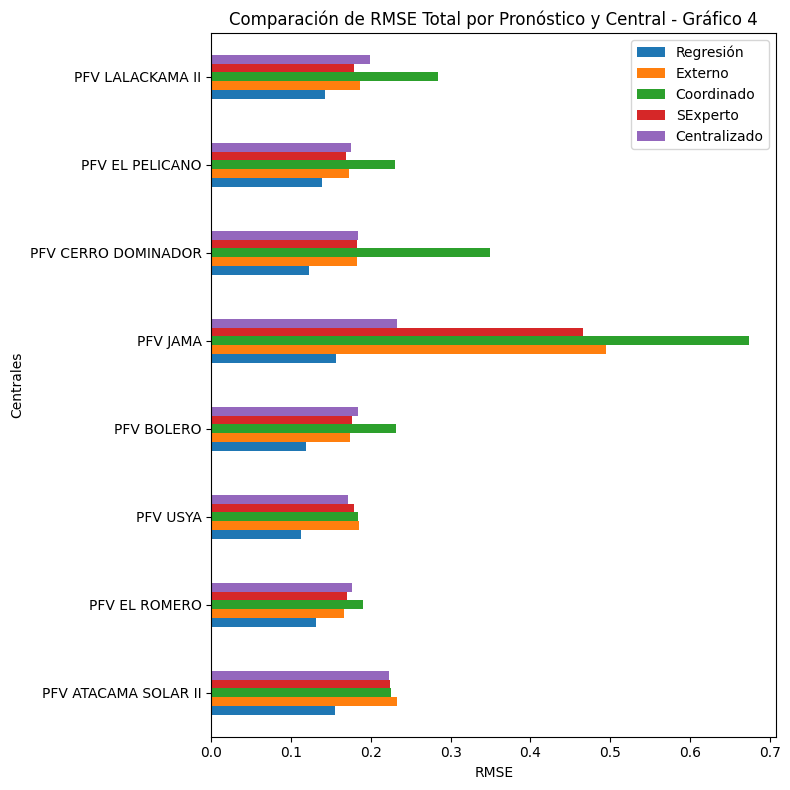

In [ ]:
# Determinar el número de gráficos necesarios
num_centrales_por_grafico = 8  # Ajusta este número según el tamaño deseado para cada gráfico
total_centrales = len(rmse_centrales)
num_graficos = total_centrales // num_centrales_por_grafico + (1 if total_centrales % num_centrales_por_grafico else 0)

for i in range(num_graficos):
    fig, ax = plt.subplots(figsize=(8, 8))  # Ajusta el tamaño como sea necesario
    # Seleccionar un subconjunto de centrales para el gráfico actual
    inicio = i * num_centrales_por_grafico
    fin = inicio + num_centrales_por_grafico
    rmse_centrales_subconjunto = rmse_centrales[inicio:fin]
    
    rmse_centrales_subconjunto.plot(kind='barh', ax=ax)
    
    # Estilizar el gráfico
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Centrales')
    ax.set_title(f'Comparación de RMSE Total por Pronóstico y Central - Gráfico {i+1}')
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [ ]:
df245.to_excel('df245.xlsx', engine='openpyxl', index=False)

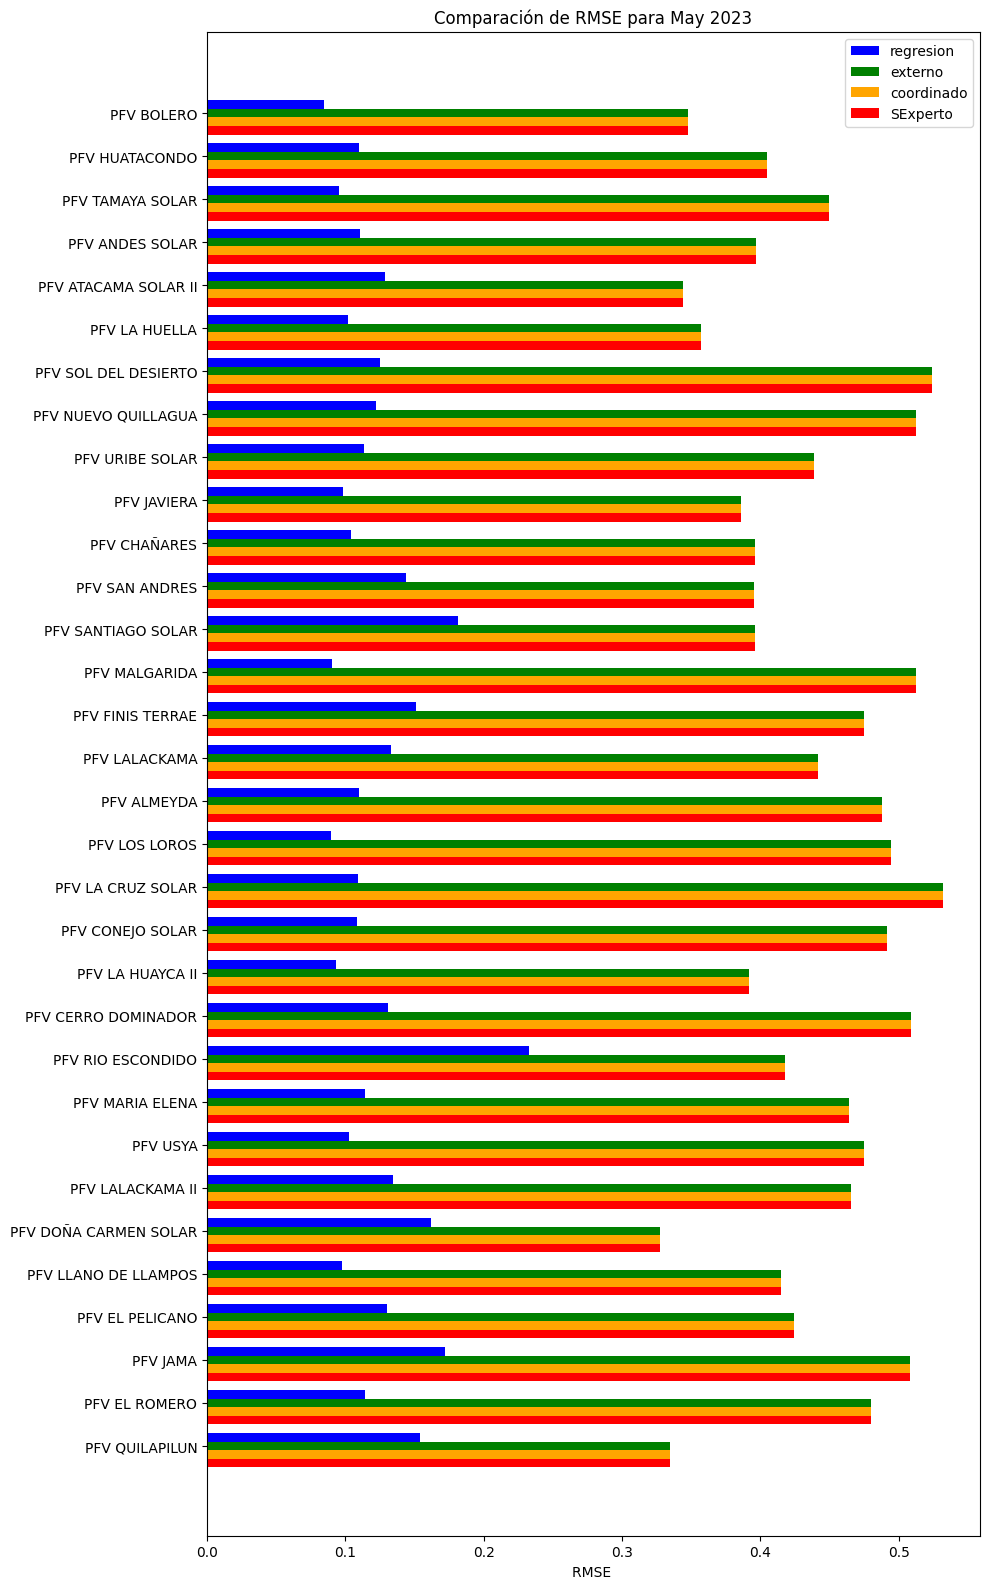

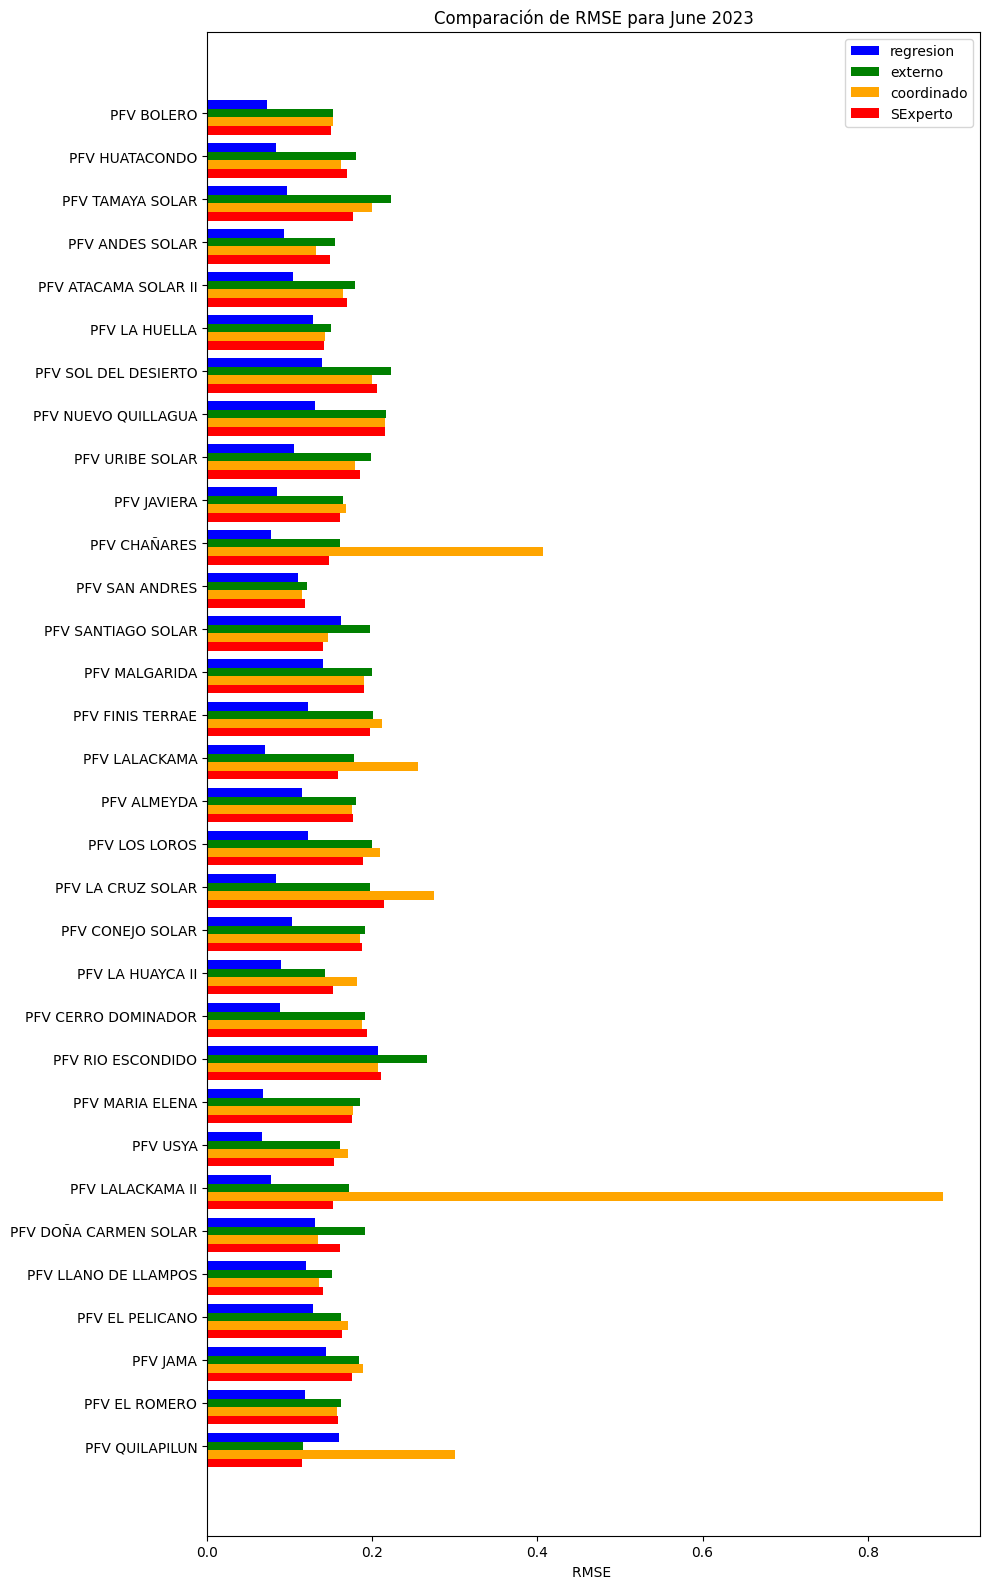

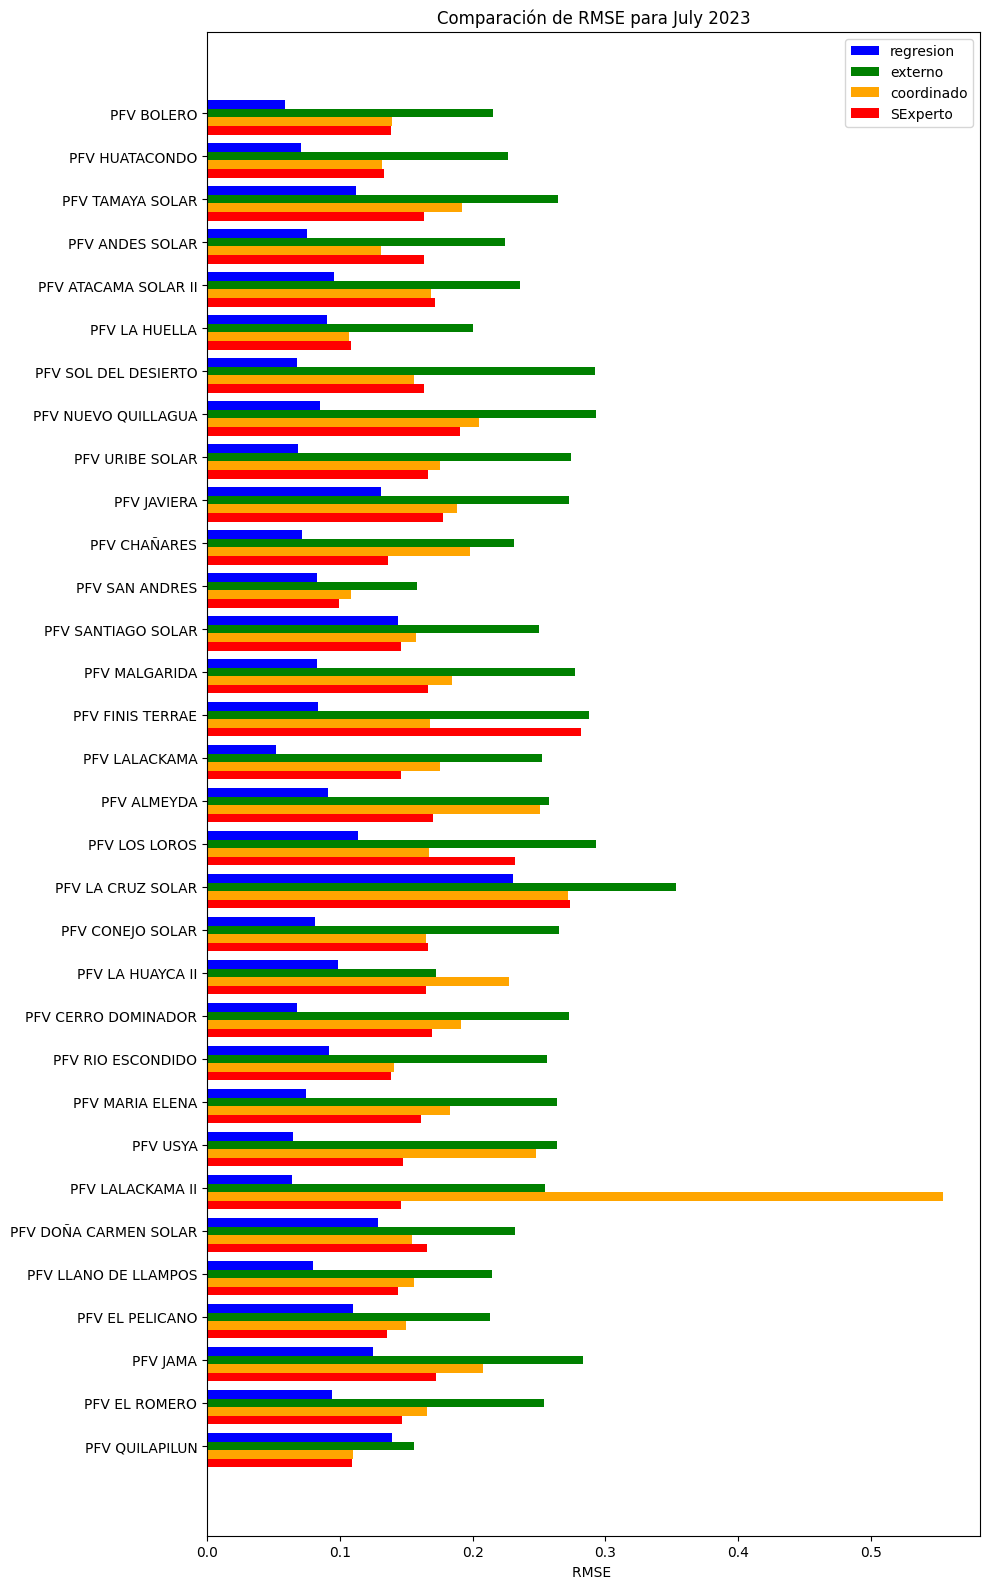

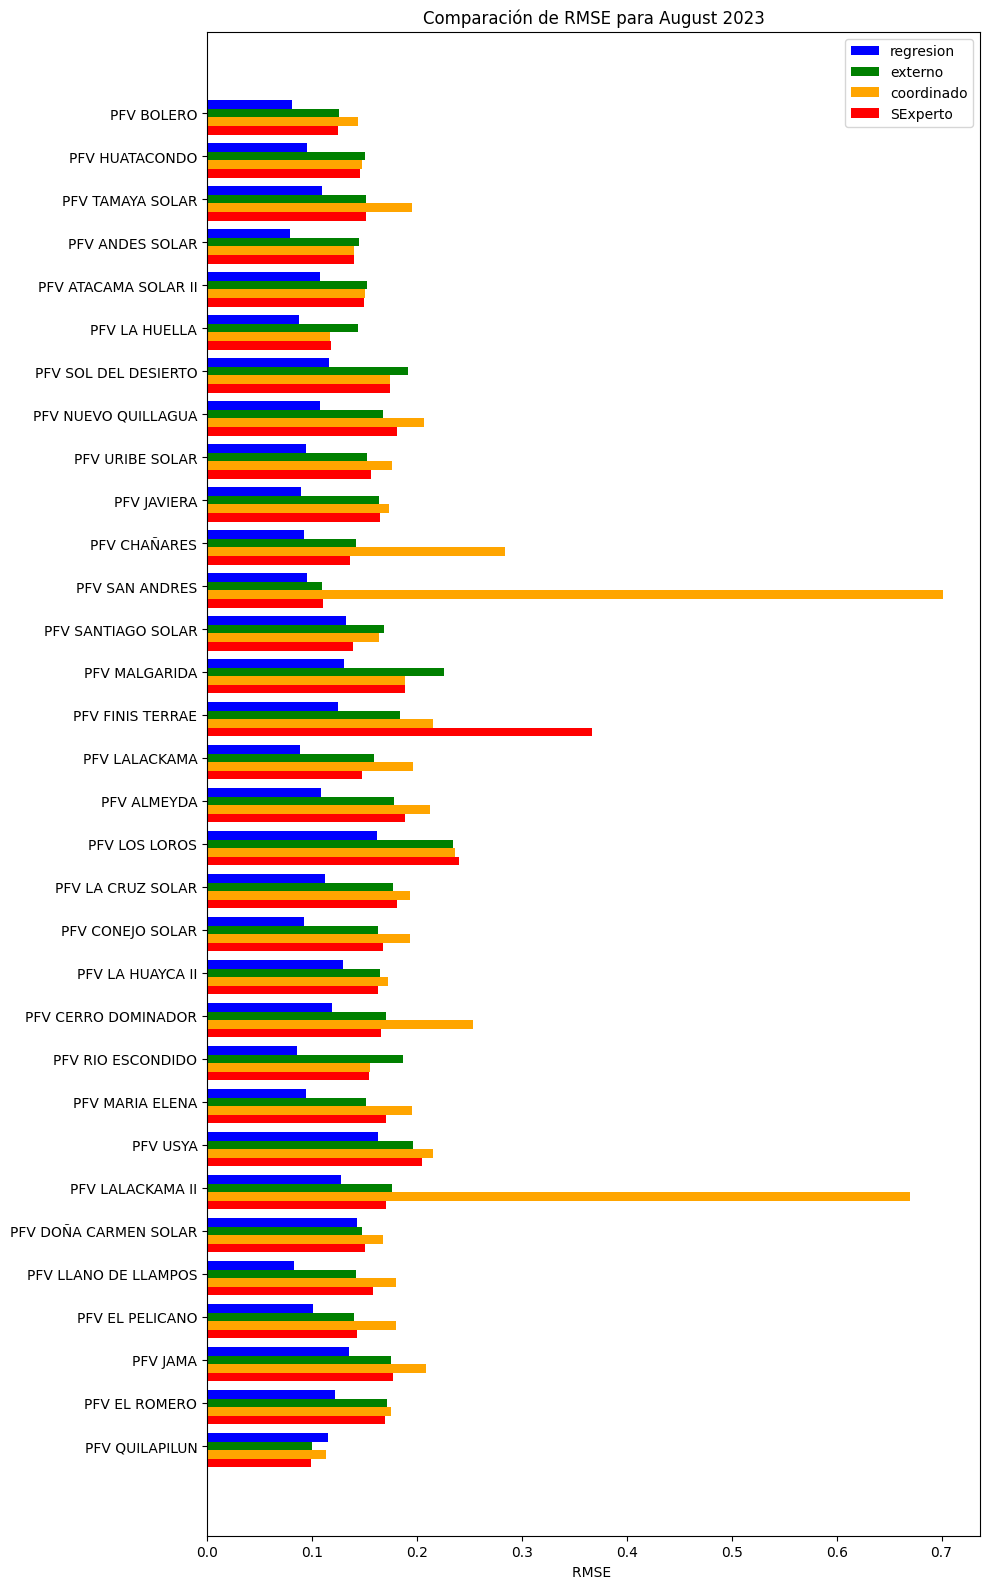

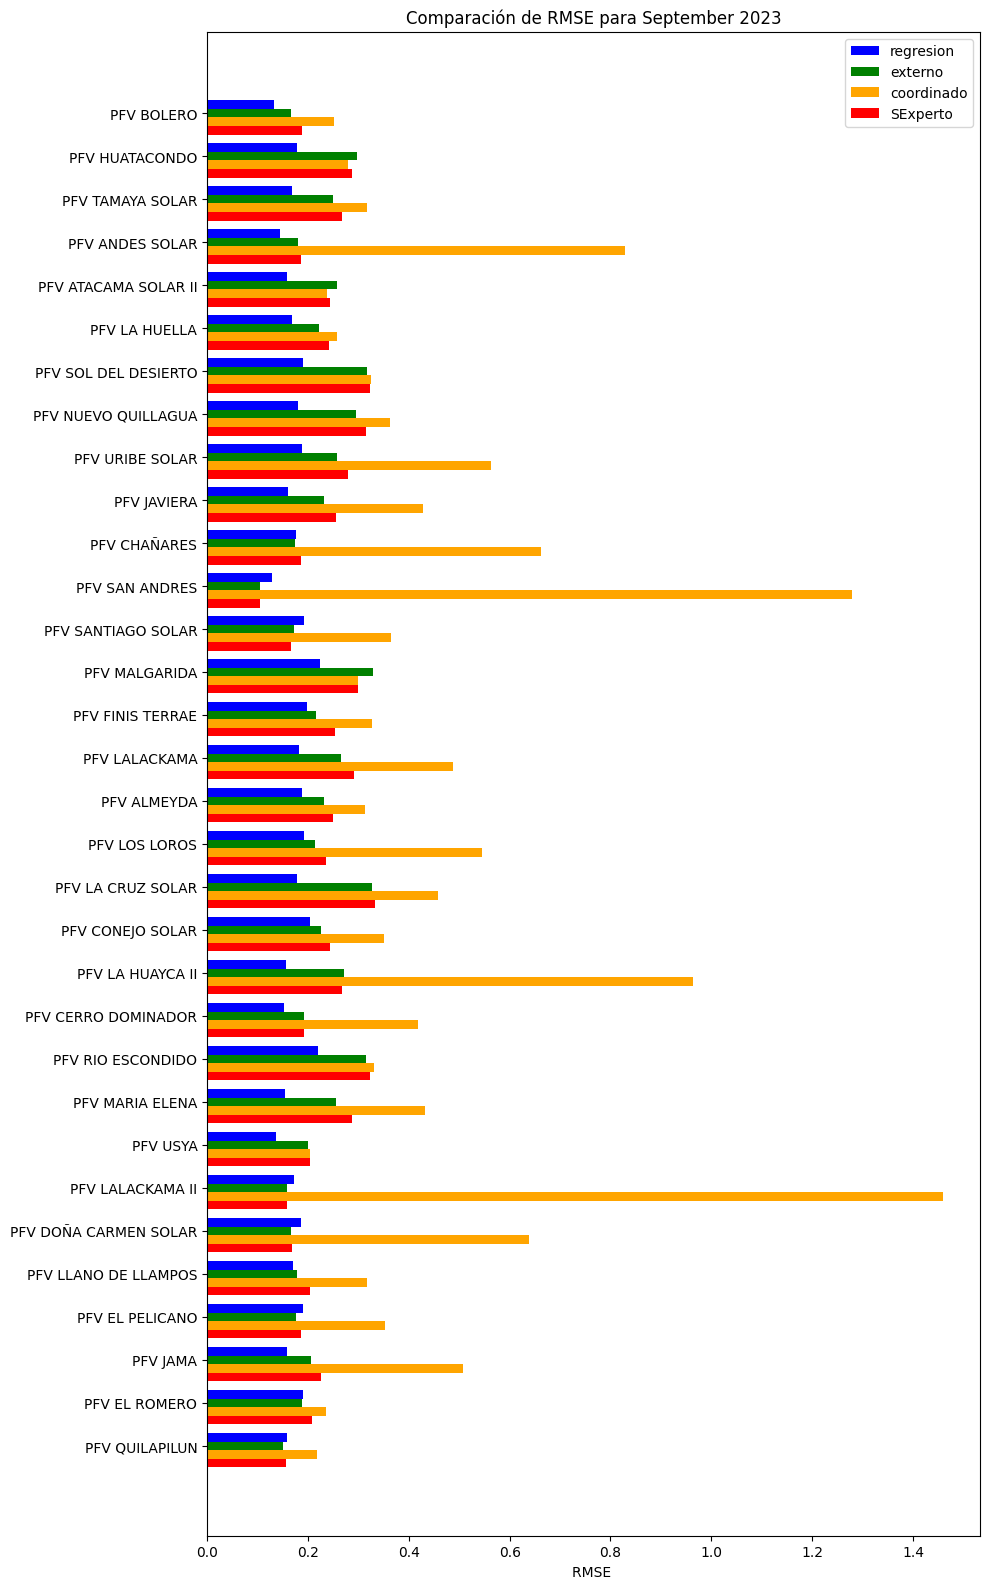

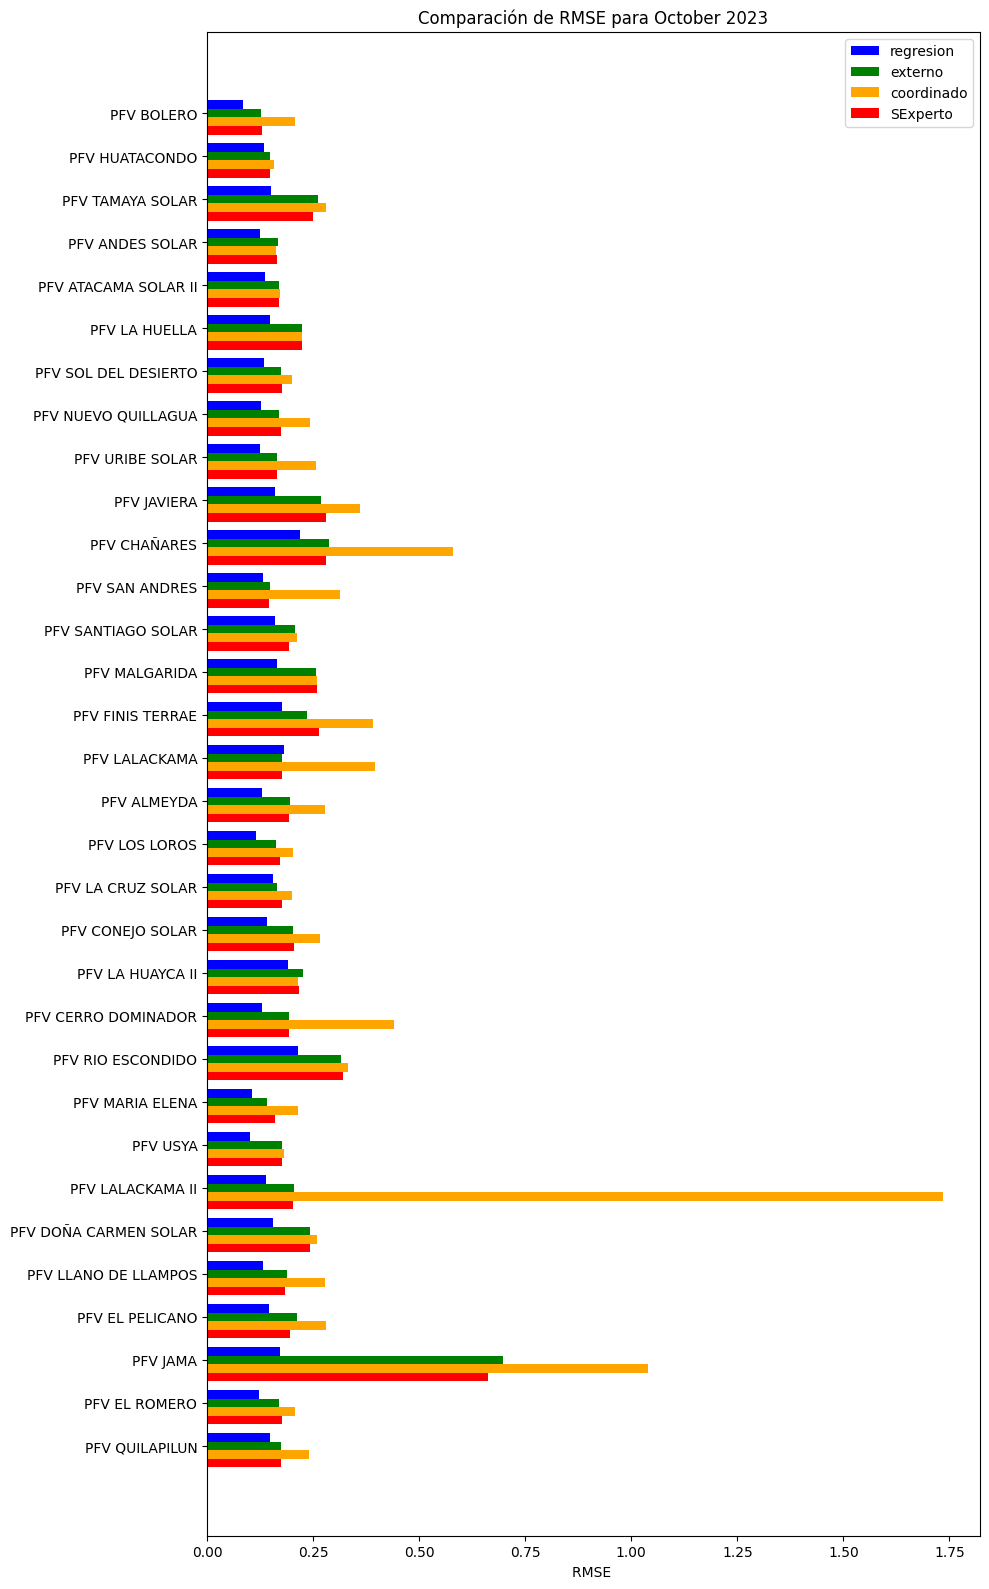

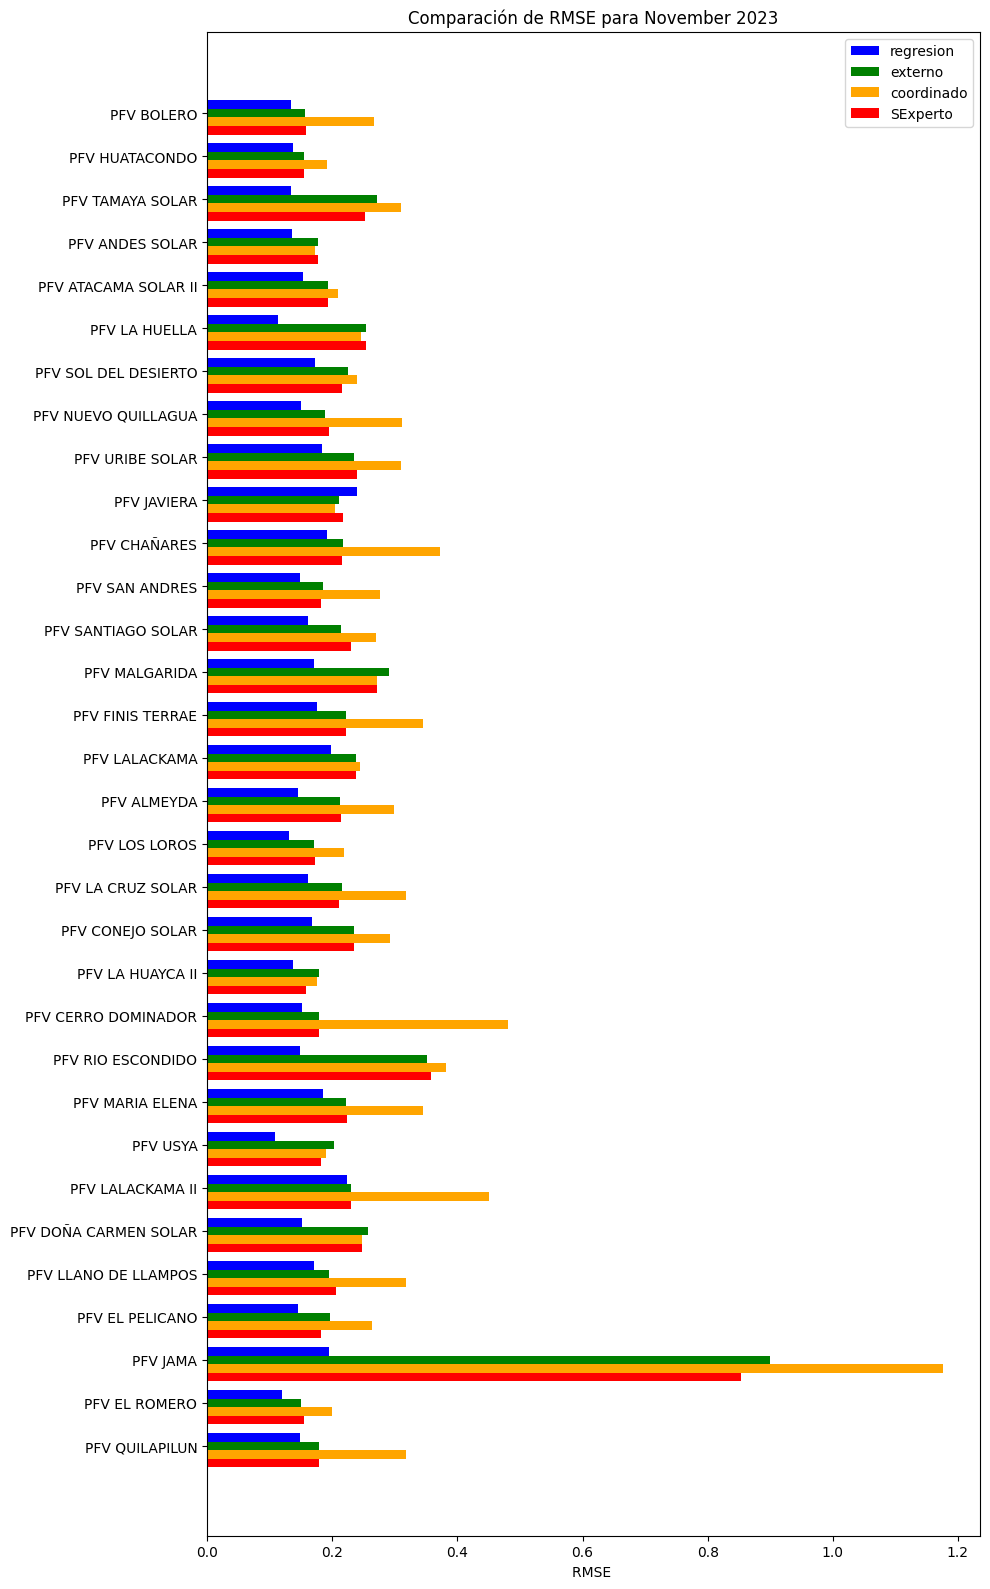

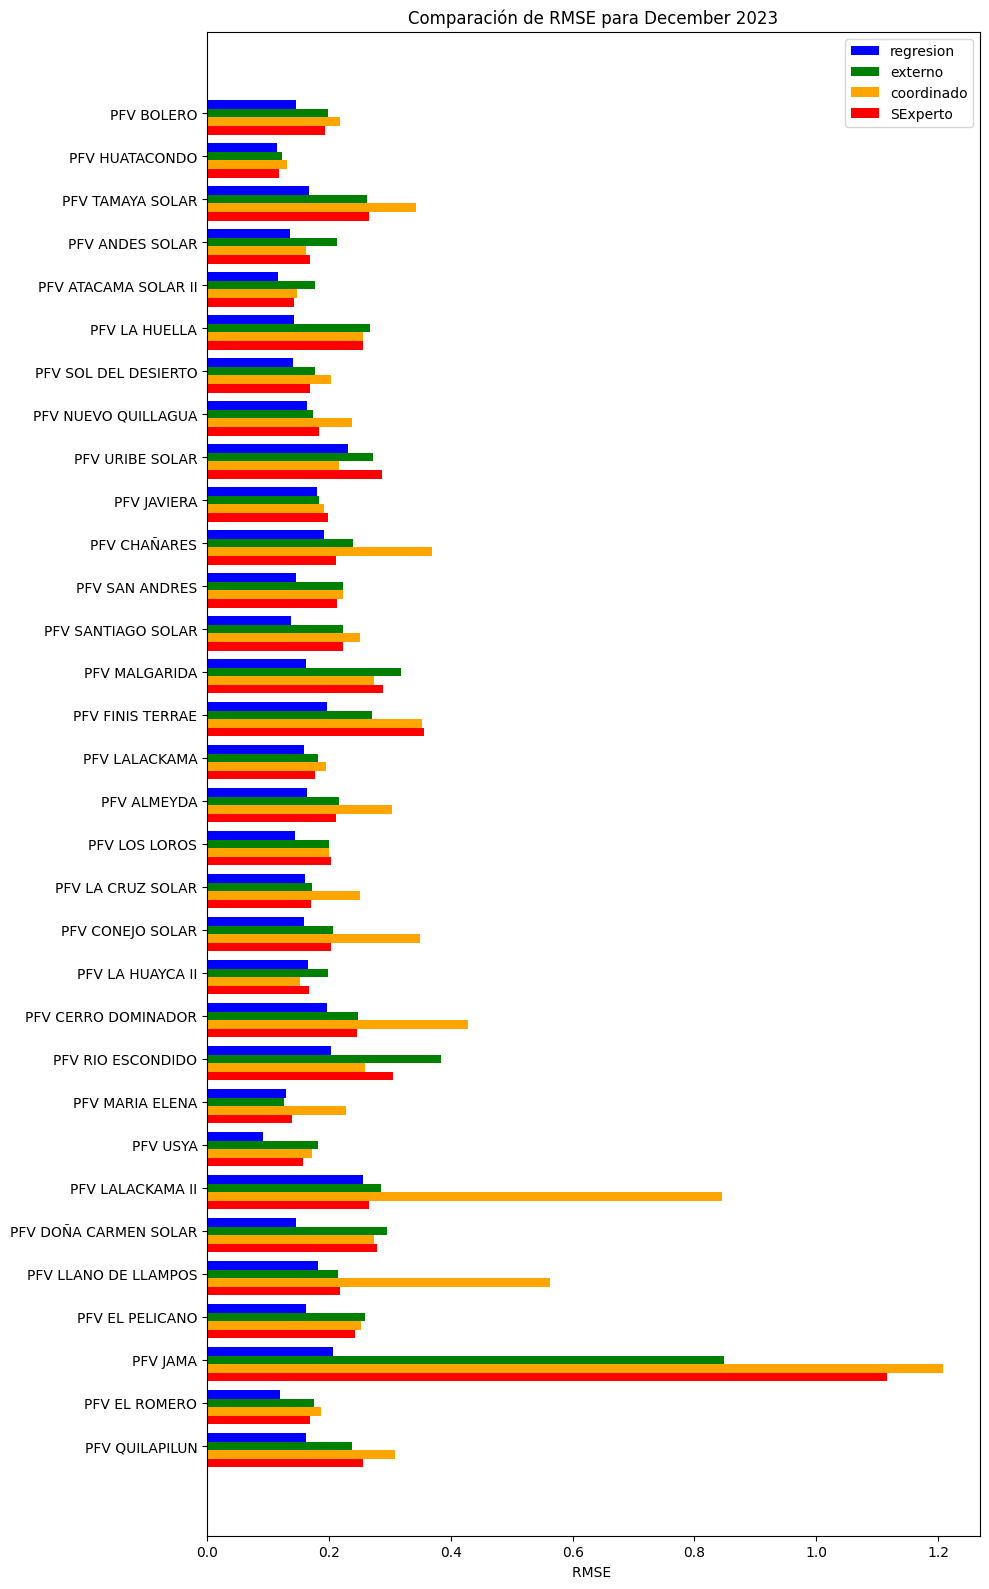

In [ ]:
# Extraer todos los meses disponibles en el conjunto de datos
meses = pd.period_range(start=min(df.index.min() for df in rmse_mensuales.values()), 
                        end=max(df.index.max() for df in rmse_mensuales.values()), freq='M')

# Estilos de las barras
estilos = ['regresion', 'externo', 'coordinado', 'SExperto']
colores = ['blue', 'green', 'orange', 'red']

# Encuentra todos los meses únicos en los datos
todos_los_meses = sorted(set(mes for central_data in rmse_mensuales.values() for mes in central_data.index))

# Tamaño de las barras
bar_width = 0.2

# Creamos un gráfico para cada mes
for mes in todos_los_meses:
    fig, ax = plt.subplots(figsize=(10, len(rmse_mensuales) * 0.5))  # Ajuste el tamaño según sea necesario
    
    # Generamos las posiciones de las barras
    indices = np.arange(len(rmse_mensuales))
    
    for i, label in enumerate(estilos):
        # Calculamos el desplazamiento para cada conjunto de barras
        offsets = [x + i * bar_width for x in indices]
        # Recopilamos los datos de RMSE para cada tipo de pronóstico
        rmse_data = [rmse_mensuales[central].loc[mes, 'RMSE_' + label] if mes in rmse_mensuales[central].index else 0 for central in rmse_mensuales]
        # Dibujamos las barras
        ax.barh(offsets, rmse_data, height=bar_width, label=label, color=colores[i])
    
    # Configuramos el gráfico
    ax.set_yticks([r + bar_width for r in range(len(rmse_mensuales))])
    ax.set_yticklabels(rmse_mensuales.keys())
    ax.set_xlabel('RMSE ')
    ax.set_title(f'Comparación de RMSE para {mes.strftime("%B %Y")}')
    ax.legend()
    ax.invert_yaxis()  # Coloca la primera central en la parte superior
    
    # Mostramos el gráfico
    plt.tight_layout()
    plt.show()

In [67]:
rmse_mensuales

{'PFV ALMEYDA':            RMSE_regresion  RMSE_externo  RMSE_coordinado  RMSE_SExperto  \
 june                  NaN           NaN              NaN            NaN   
 july             0.114825      0.180556         0.174972       0.176145   
 august           0.091081      0.167508         0.177417       0.170096   
 september        0.109432      0.178398         0.212020       0.188738   
 october          0.187454      0.230092         0.310897       0.247808   
 november         0.128066      0.196780         0.277911       0.193919   
 december         0.145333      0.211602         0.297052       0.212116   
 
            RMSE_Centralizado  
 june                     NaN  
 july                0.180556  
 august              0.168696  
 september           0.186536  
 october             0.247806  
 november            0.196320  
 december            0.212290  ,
 'PFV LALACKAMA':            RMSE_regresion  RMSE_externo  RMSE_coordinado  RMSE_SExperto  \
 june                  Na

In [78]:

# Step 1: Initialize the DataFrame
months = ['junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
forecast_methods = ['Externo', 'Coordinados', 'SExperto', 'Centralizado', 'Regresión']
results_df = pd.DataFrame(0, index=months + ['Agregado'], columns=forecast_methods)

# Define a mapping from PeriodIndex month numbers to Spanish month names
month_number_to_spanish = {
    6: 'junio',
    7: 'julio',
    8: 'agosto',
    9: 'septiembre',
    10: 'octubre',
    11: 'noviembre',
    12: 'diciembre'
}

# Step 2: Populate the DataFrame
for central, monthly_data in rmse_mensuales.items():
    # Convert string index to PeriodIndex if necessary
    if isinstance(monthly_data.index, pd.PeriodIndex):
        monthly_data['Month'] = monthly_data.index.month
    else:
        monthly_data['Month'] = pd.PeriodIndex(monthly_data.index, freq='M').month
    
    for month_number, data in monthly_data.groupby('Month'):
        spanish_month = month_number_to_spanish.get(month_number)
        if spanish_month in results_df.index:
            min_rmse_method = data.mean().idxmin().lstrip('RMSE_')
            results_df.loc[spanish_month, min_rmse_method] += 1

# Step 3: Add the 'Agregado' row
results_df.loc['Agregado'] = results_df.sum(axis=0)

# Ensure all counts are integers (optional)
results_df = results_df.astype(int)

# Display the resulting DataFrame
print(results_df)



ValueError: time data "june" doesn't match format "%Y-%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.